In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


In [2]:
# Load the dataset
file_path = "PODD.csv"  # Path to the dataset file
data = pd.read_csv(file_path)  # Read the dataset into a pandas DataFrame
data_close = data['Close'].values.reshape(-1, 1)  # Extract the 'Close' column and reshape it into a 2D array for further processing

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))  # Initialize a MinMaxScaler to scale values between 0 and 1
data_normalized = scaler.fit_transform(data_close)  # Apply normalization to the 'Close' column data
original_min, original_max = scaler.data_min_, scaler.data_max_


In [3]:
# Create sequences for input and output
def create_sequences(data, seq_length=30):
    """
    Creates sequences of data for time-series prediction.
    Each input (X) is a sequence of length `seq_length`,
    and the target (y) is the value immediately after the sequence.
    """
    X, y = [], []
    for i in range(len(data) - seq_length):  # Iterate until the end of the dataset
        X.append(data[i:i+seq_length])  # Append sequence of length `seq_length`
        y.append(data[i+seq_length])  # Append the target value
    return np.array(X), np.array(y)


In [4]:
# Parameters for sequence creation and train-test split
seq_length = 30
X, y = create_sequences(data_normalized, seq_length)  # Create input-output pairs
# Split data into train, validation, and test sets
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)  # Split off test set
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.3, shuffle=False)  # Split remaining into train and validation

# Convert data to PyTorch tensors for model input
X_train, y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32)
X_val, y_val = torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32)
X_test, y_test = torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)


In [5]:

# Define the RNN-based stock price prediction model
class StockPriceRNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=2, output_size=1, rnn_type="LSTM"):
        """
        Initializes the RNN model with specified parameters:
        - input_size: Number of input features
        - hidden_size: Number of units in the hidden layer
        - num_layers: Number of RNN layers
        - output_size: Number of output features
        - rnn_type: Type of RNN ('LSTM', 'GRU', or 'RNN')
        """
        super(StockPriceRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # Select RNN type
        if rnn_type == "LSTM":
            self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        elif rnn_type == "GRU":
            self.rnn = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        else:
            self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        # Fully connected layer to output predictions
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        """
        Defines the forward pass for the RNN model.
        - x: Input tensor of shape (batch_size, seq_length, input_size)
        """
        # Initialize hidden states (and cell states for LSTM)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        if isinstance(self.rnn, nn.LSTM):
            c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
            out, _ = self.rnn(x, (h0, c0))  # Forward pass for LSTM
        else:
            out, _ = self.rnn(x, h0)  # Forward pass for GRU/RNN
        out = self.fc(out[:, -1, :])  # Fully connected layer on the last hidden state
        return out


In [6]:
import matplotlib.pyplot as plt

def plot_full_validation_predictions(model, X_val, y_val, scaler, model_name="Model"):
    """
    Function to plot predictions vs. true values for the entire validation set.
    
    Args:
    - model: Trained model to evaluate.
    - X_val: Validation features (tensor).
    - y_val: Validation targets (tensor).
    - scaler: MinMaxScaler used to normalize the data.
    - model_name: Name of the model for the plot title.
    """
    model.eval()  # Set the model to evaluation mode
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    X_val, y_val = X_val.to(device), y_val.to(device)
    
    with torch.no_grad():
        val_predictions = model(X_val)  # Get predictions on the validation set

    # Denormalize the predictions and true values
    val_predictions = val_predictions.cpu().numpy()
    y_val = y_val.cpu().numpy()
    min_val, max_val = scaler.data_min_, scaler.data_max_
    val_predictions_denorm = val_predictions * (max_val - min_val) + min_val
    y_val_denorm = y_val * (max_val - min_val) + min_val

    # Plot the entire validation set
    plt.figure(figsize=(12, 6))
    plt.plot(y_val_denorm, label="True Values", color="blue", alpha=0.6)
    plt.plot(val_predictions_denorm, label="Predicted Values", color="orange", alpha=0.6)
    plt.title(f"{model_name}: Validation Predictions vs. True Values")
    plt.xlabel("Samples")
    plt.ylabel("Stock Price")
    plt.legend()
    plt.grid(True)
    plt.show()


# GRU

In [ ]:
# Model hyperparameters
input_size = 1
hidden_size = 50
num_layers = 1
output_size = 1
learning_rate = 0.001
num_epochs = 200
rnn_type = "GRU"  # Choose between "LSTM", "GRU", and "RNN"

# Initialize the RNN model, loss functions, and optimizer
modelGRU = StockPriceRNN(input_size, hidden_size, num_layers, output_size, rnn_type).to('cuda' if torch.cuda.is_available() else 'cpu')
criterion_mse = nn.MSELoss()  # Mean Squared Error for training
criterion_mae = nn.L1Loss()  # Mean Absolute Error for evaluation
optimizer = optim.Adam(modelGRU.parameters(), lr=learning_rate)  # Adam optimizer

# Move data to appropriate device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
X_train, y_train = X_train.to(device), y_train.to(device)
X_val, y_val = X_val.to(device), y_val.to(device)


In [8]:
# Track training and validation losses
train_mse_vals, train_mae_vals = [], []  # Lists to store training losses
val_mse_vals, val_mae_vals = [], []  # Lists to store validation losses

# Initialize variables for best validation MSE tracking
best_val_mse = float('inf')  # Start with a very high MSE value
best_model_path = "best_modelGRU.pth"  # Path to save the best model
best_epoch = -1  # Variable to store the epoch of the best model
best_val_mae = None  # Variable to store the corresponding MAE of the best model

# Training loop
for epoch in range(num_epochs):
    # Training phase
    modelGRU.train()
    optimizer.zero_grad()
    outputs = modelGRU(X_train)
    train_loss_mse = criterion_mse(outputs, y_train)
    train_loss_mae = criterion_mae(outputs, y_train)
    train_loss_mse.backward()
    optimizer.step()

    # Inverse scaling for training metrics
    outputs_original = scaler.inverse_transform(outputs.detach().cpu().numpy())
    y_train_original = scaler.inverse_transform(y_train.cpu().numpy())

    train_mse_original = ((outputs_original - y_train_original) ** 2).mean()
    train_mae_original = abs(outputs_original - y_train_original).mean()

    # Record training losses
    train_mse_vals.append(train_mse_original)
    train_mae_vals.append(train_mae_original)

    # Validation phase
    modelGRU.eval()
    with torch.no_grad():
        val_outputs = modelGRU(X_val)
        val_loss_mse = criterion_mse(val_outputs, y_val)
        val_loss_mae = criterion_mae(val_outputs, y_val)

        # Inverse scaling for validation metrics
        val_outputs_original = scaler.inverse_transform(val_outputs.cpu().numpy())
        y_val_original = scaler.inverse_transform(y_val.cpu().numpy())

        val_mse_original = ((val_outputs_original - y_val_original) ** 2).mean()
        val_mae_original = abs(val_outputs_original - y_val_original).mean()

        # Record validation losses
        val_mse_vals.append(val_mse_original)
        val_mae_vals.append(val_mae_original)

        # Save the model if validation MSE improves
        if val_mse_original < best_val_mse:
            best_val_mse = val_mse_original
            best_epoch = epoch + 1
            best_val_mae = val_mae_original
            torch.save(modelGRU.state_dict(), best_model_path)
            print(f"Epoch {best_epoch}: Validation MSE improved to {best_val_mse:.4f}, "
                  f"Validation MAE: {best_val_mae:.4f}, model saved!")

    # Print loss information for the epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train MSE : {train_mse_original:.4f}, Val MSE : {val_mse_original:.4f}, '
          f'Train MAE : {train_mae_original:.4f}, Val MAE : {val_mae_original:.4f}')


Epoch 1: Validation MSE improved to 479.3524, Validation MAE: 20.2448, model saved!
Epoch [1/200], Train MSE : 2416.6077, Val MSE : 479.3524, Train MAE : 48.0025, Val MAE : 20.2448
Epoch 2: Validation MSE improved to 273.9891, Validation MAE: 14.4625, model saved!
Epoch [2/200], Train MSE : 1500.2352, Val MSE : 273.9891, Train MAE : 37.2580, Val MAE : 14.4625
Epoch [3/200], Train MSE : 834.2821, Val MSE : 278.4569, Train MAE : 26.9045, Val MAE : 11.5662
Epoch [4/200], Train MSE : 396.5859, Val MSE : 465.5205, Train MAE : 17.8102, Val MAE : 14.8341
Epoch [5/200], Train MSE : 166.0274, Val MSE : 793.3088, Train MAE : 11.6875, Val MAE : 23.3237
Epoch [6/200], Train MSE : 112.2806, Val MSE : 1190.6425, Train MAE : 7.9618, Val MAE : 30.6950
Epoch [7/200], Train MSE : 185.6039, Val MSE : 1553.5614, Train MAE : 10.1200, Val MAE : 36.1372
Epoch [8/200], Train MSE : 310.3622, Val MSE : 1793.4878, Train MAE : 14.3429, Val MAE : 39.3249
Epoch [9/200], Train MSE : 411.3853, Val MSE : 1882.8866, Tr

In [9]:
print(f"Best Model Saved at Epoch {best_epoch}, with Validation MSE: {best_val_mse:.6f}, "
      f"and Validation MAE: {best_val_mae:.6f}")

Best Model Saved at Epoch 186, with Validation MSE: 3.500524, and Validation MAE: 1.359184


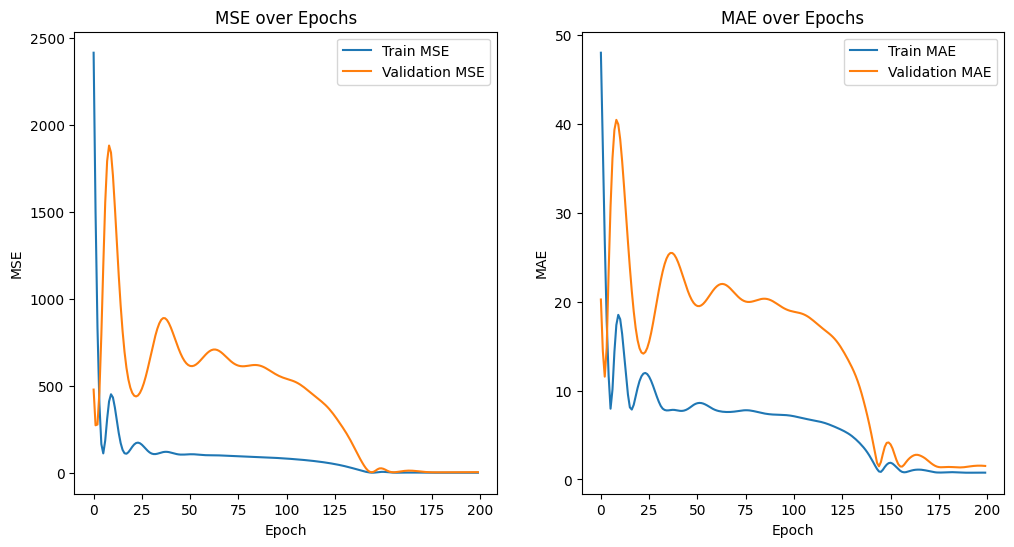

In [10]:
# Plot training and validation losses over epochs
plt.figure(figsize=(12, 6))

# Plot MSE
plt.subplot(1, 2, 1)
plt.plot(train_mse_vals, label='Train MSE')  # Plot training MSE
plt.plot(val_mse_vals, label='Validation MSE')  # Plot validation MSE
plt.title('MSE over Epochs')  # Title for the MSE plot
plt.xlabel('Epoch')  # X-axis label
plt.ylabel('MSE')  # Y-axis label
plt.legend()  # Display legend

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(train_mae_vals, label='Train MAE')  # Plot training MAE
plt.plot(val_mae_vals, label='Validation MAE')  # Plot validation MAE
plt.title('MAE over Epochs')  # Title for the MAE plot
plt.xlabel('Epoch')  # X-axis label
plt.ylabel('MAE')  # Y-axis label
plt.legend()  # Display legend

# Show plots
plt.show()

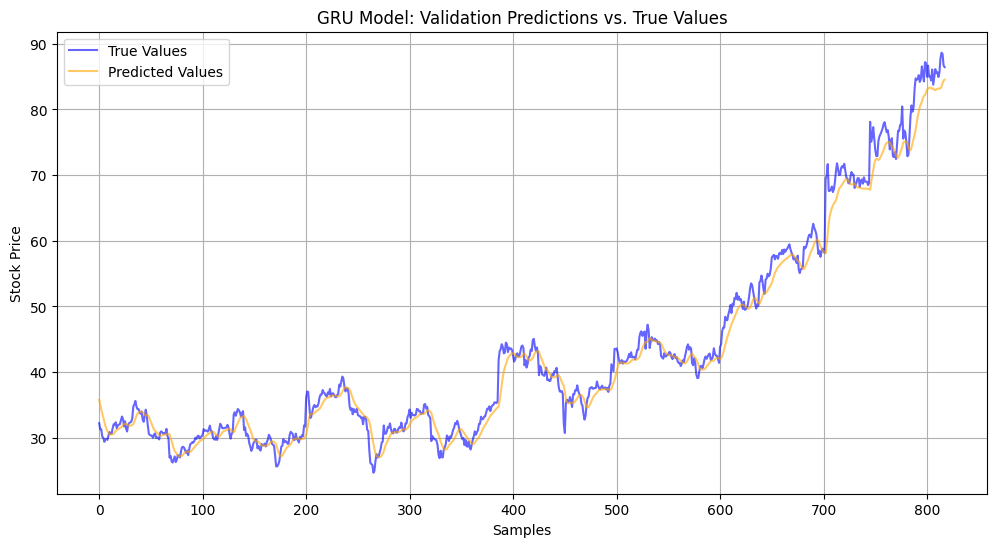

In [11]:
plot_full_validation_predictions(modelGRU, X_val, y_val, scaler, model_name="GRU Model")

### GRU model 2, hidden units to 128

In [12]:
# Define the GRU model with a hidden size of 128
hidden_size = 128  # Set the hidden size for this experiment

print(f"Experimenting with Hidden Size: {hidden_size}")
# Initialize the GRU model
modelGRU2 = StockPriceRNN(
    input_size=input_size,
    hidden_size=hidden_size,
    num_layers=num_layers,  # Keep layers constant for now
    output_size=output_size,
    rnn_type="GRU"
).to(device)

# Loss functions and optimizer
criterion_mse = nn.MSELoss()
criterion_mae = nn.L1Loss()
optimizer = optim.Adam(modelGRU2.parameters(), lr=learning_rate)


Experimenting with Hidden Size: 128


In [13]:
# Track training and validation losses
train_mse_vals, train_mae_vals = [], []  # Lists to store training losses
val_mse_vals, val_mae_vals = [], []  # Lists to store validation losses

# Initialize variables for best validation MSE tracking
best_val_mse = float('inf')  # Start with a very high MSE value
best_model_path = "best_modelGRU2.pth"  # Path to save the best model
best_epoch = -1  # Variable to store the epoch of the best model
best_val_mae = None  # Variable to store the corresponding MAE of the best model

# Training loop
for epoch in range(num_epochs):
    # Training phase
    modelGRU2.train()
    optimizer.zero_grad()
    outputs = modelGRU2(X_train)
    train_loss_mse = criterion_mse(outputs, y_train)
    train_loss_mae = criterion_mae(outputs, y_train)
    train_loss_mse.backward()
    optimizer.step()

    # Inverse scaling for training metrics
    outputs_original = scaler.inverse_transform(outputs.detach().cpu().numpy())
    y_train_original = scaler.inverse_transform(y_train.cpu().numpy())

    train_mse_original = ((outputs_original - y_train_original) ** 2).mean()
    train_mae_original = abs(outputs_original - y_train_original).mean()

    # Record training losses
    train_mse_vals.append(train_mse_original)
    train_mae_vals.append(train_mae_original)

    # Validation phase
    modelGRU2.eval()
    with torch.no_grad():
        val_outputs = modelGRU2(X_val)
        val_loss_mse = criterion_mse(val_outputs, y_val)
        val_loss_mae = criterion_mae(val_outputs, y_val)

        # Inverse scaling for validation metrics
        val_outputs_original = scaler.inverse_transform(val_outputs.cpu().numpy())
        y_val_original = scaler.inverse_transform(y_val.cpu().numpy())

        val_mse_original = ((val_outputs_original - y_val_original) ** 2).mean()
        val_mae_original = abs(val_outputs_original - y_val_original).mean()

        # Record validation losses
        val_mse_vals.append(val_mse_original)
        val_mae_vals.append(val_mae_original)

        # Save the model if validation MSE improves
        if val_mse_original < best_val_mse:
            best_val_mse = val_mse_original
            best_epoch = epoch + 1
            best_val_mae = val_mae_original
            torch.save(modelGRU2.state_dict(), best_model_path)
            

In [14]:
print(f"Best Model Saved at Epoch {best_epoch}, with Validation MSE: {best_val_mse:.6f}, "
      f"and Validation MAE: {best_val_mae:.6f}")

Best Model Saved at Epoch 200, with Validation MSE: 2.974770, and Validation MAE: 1.210085


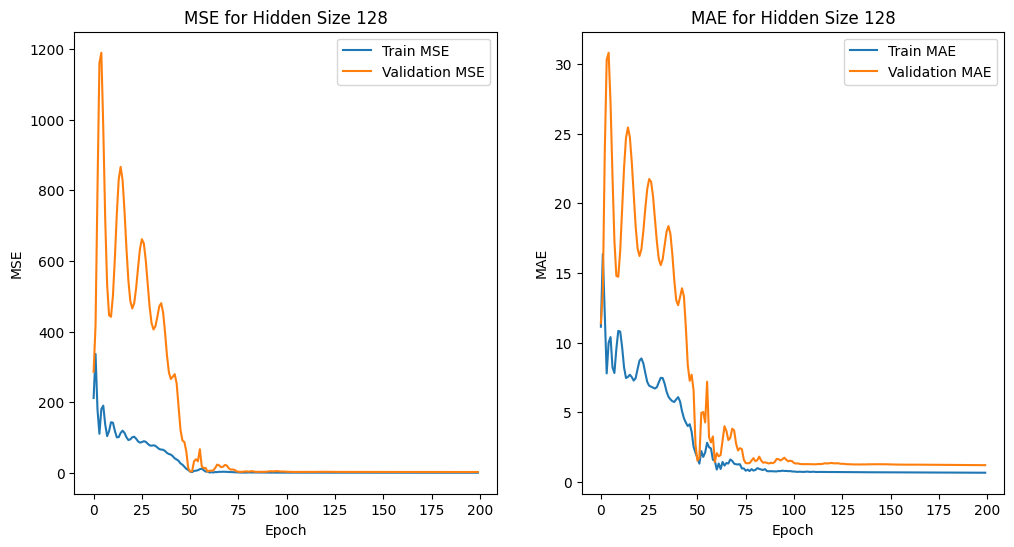

In [15]:
# Plot training and validation losses
plt.figure(figsize=(12, 6))

# Plot MSE
plt.subplot(1, 2, 1)
plt.plot(train_mse_vals, label='Train MSE')
plt.plot(val_mse_vals, label='Validation MSE')
plt.title(f'MSE for Hidden Size {hidden_size}')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(train_mae_vals, label='Train MAE')
plt.plot(val_mae_vals, label='Validation MAE')
plt.title(f'MAE for Hidden Size {hidden_size}')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.show()

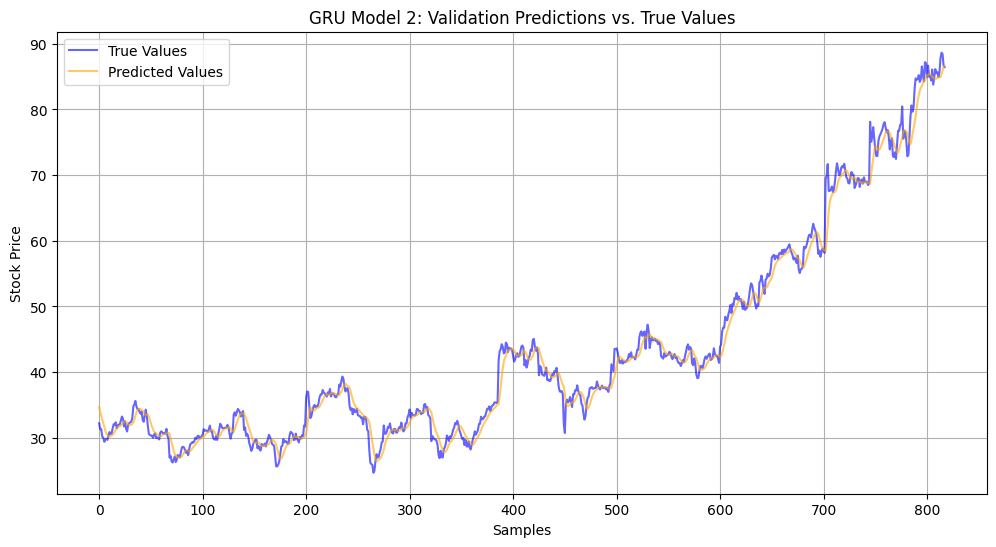

In [16]:
plot_full_validation_predictions(modelGRU2, X_val, y_val, scaler, model_name="GRU Model 2")

### GRU model 3, adding multiple layer gru

In [17]:
# Define the GRU model with multiple layers (e.g., 2 layers)
hidden_size = 128  # Keep the hidden size from the previous experiment
num_layers = 2  # Set the number of GRU layers for this experiment

print(f"Experimenting with Hidden Size: {hidden_size} and Number of Layers: {num_layers}")
# Initialize the GRU model
modelGRU3 = StockPriceRNN(
    input_size=input_size,
    hidden_size=hidden_size,
    num_layers=num_layers,  # Set multiple layers
    output_size=output_size,
    rnn_type="GRU"
).to(device)

# Loss functions and optimizer
criterion_mse = nn.MSELoss()
criterion_mae = nn.L1Loss()
optimizer = optim.Adam(modelGRU3.parameters(), lr=learning_rate)


Experimenting with Hidden Size: 128 and Number of Layers: 2


In [18]:
# Track training and validation losses
train_mse_vals, train_mae_vals = [], []  # Lists to store training losses
val_mse_vals, val_mae_vals = [], []  # Lists to store validation losses

# Initialize variables for best validation MSE tracking
best_val_mse = float('inf')  # Start with a very high MSE value
best_model_path = "best_modelGRU3.pth"  # Path to save the best model
best_epoch = -1  # Variable to store the epoch of the best model
best_val_mae = None  # Variable to store the corresponding MAE of the best model

# Training loop
for epoch in range(num_epochs):
    # Training phase
    modelGRU3.train()
    optimizer.zero_grad()
    outputs = modelGRU3(X_train)
    train_loss_mse = criterion_mse(outputs, y_train)
    train_loss_mae = criterion_mae(outputs, y_train)
    train_loss_mse.backward()
    optimizer.step()

    # Inverse scaling for training metrics
    outputs_original = scaler.inverse_transform(outputs.detach().cpu().numpy())
    y_train_original = scaler.inverse_transform(y_train.cpu().numpy())

    train_mse_original = ((outputs_original - y_train_original) ** 2).mean()
    train_mae_original = abs(outputs_original - y_train_original).mean()

    # Record training losses
    train_mse_vals.append(train_mse_original)
    train_mae_vals.append(train_mae_original)

    # Validation phase
    modelGRU3.eval()
    with torch.no_grad():
        val_outputs = modelGRU3(X_val)
        val_loss_mse = criterion_mse(val_outputs, y_val)
        val_loss_mae = criterion_mae(val_outputs, y_val)

        # Inverse scaling for validation metrics
        val_outputs_original = scaler.inverse_transform(val_outputs.cpu().numpy())
        y_val_original = scaler.inverse_transform(y_val.cpu().numpy())

        val_mse_original = ((val_outputs_original - y_val_original) ** 2).mean()
        val_mae_original = abs(val_outputs_original - y_val_original).mean()

        # Record validation losses
        val_mse_vals.append(val_mse_original)
        val_mae_vals.append(val_mae_original)

        # Save the model if validation MSE improves
        if val_mse_original < best_val_mse:
            best_val_mse = val_mse_original
            best_epoch = epoch + 1
            best_val_mae = val_mae_original
            torch.save(modelGRU3.state_dict(), best_model_path)
            

In [19]:
print(f"Best Model Saved at Epoch {best_epoch}, with Validation MSE: {best_val_mse:.6f}, "
      f"and Validation MAE: {best_val_mae:.6f}")

Best Model Saved at Epoch 200, with Validation MSE: 3.174400, and Validation MAE: 1.252866


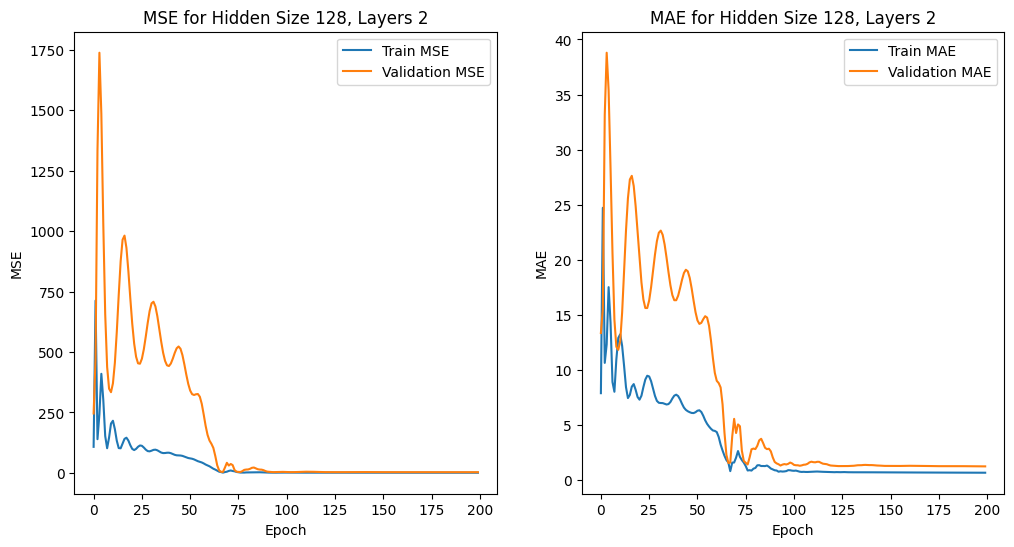

In [20]:
# Plot training and validation losses
plt.figure(figsize=(12, 6))

# Plot MSE
plt.subplot(1, 2, 1)
plt.plot(train_mse_vals, label='Train MSE')
plt.plot(val_mse_vals, label='Validation MSE')
plt.title(f'MSE for Hidden Size {hidden_size}, Layers {num_layers}')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(train_mae_vals, label='Train MAE')
plt.plot(val_mae_vals, label='Validation MAE')
plt.title(f'MAE for Hidden Size {hidden_size}, Layers {num_layers}')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.show()

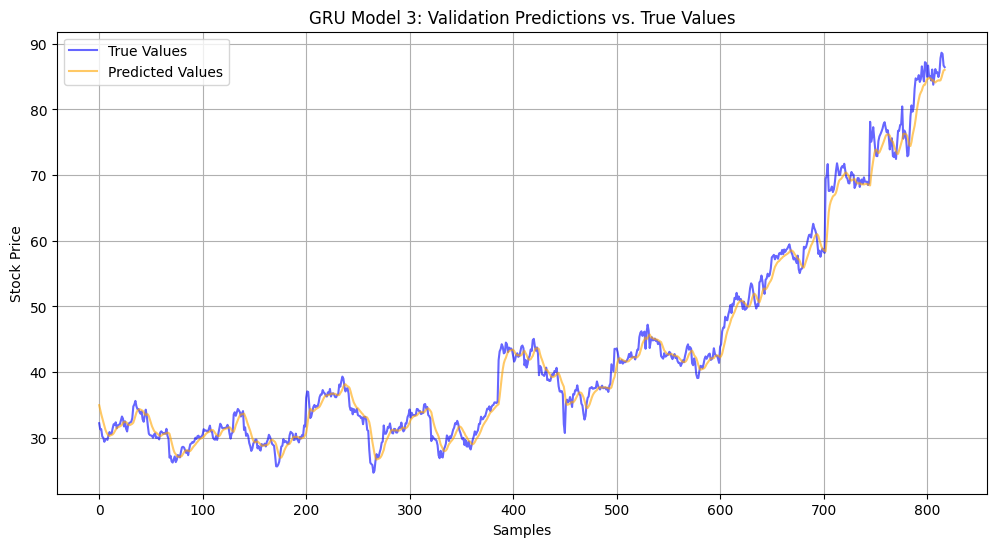

In [21]:
plot_full_validation_predictions(modelGRU3, X_val, y_val, scaler, model_name="GRU Model 3")

### GRU model 4, decrease learning rate to 0.0001

In [22]:
# Define the GRU model with decreased learning rate
hidden_size = 128  # Keep the hidden size constant
num_layers = 2  # Keep the number of layers constant
learning_rate = 0.0001  # Decrease the learning rate for this experiment

print(f"Experimenting with Hidden Size: {hidden_size}, Layers: {num_layers}, Learning Rate: {learning_rate}")
# Initialize the GRU model
modelGRU4 = StockPriceRNN(
    input_size=input_size,
    hidden_size=hidden_size,
    num_layers=num_layers,
    output_size=output_size,
    rnn_type="GRU"
).to(device)

# Loss functions and optimizer
criterion_mse = nn.MSELoss()
criterion_mae = nn.L1Loss()
optimizer = optim.Adam(modelGRU4.parameters(), lr=learning_rate)


Experimenting with Hidden Size: 128, Layers: 2, Learning Rate: 0.0001


In [23]:
# Track training and validation losses
train_mse_vals, train_mae_vals = [], []  # Lists to store training losses
val_mse_vals, val_mae_vals = [], []  # Lists to store validation losses

# Initialize variables for best validation MSE tracking
best_val_mse = float('inf')  # Start with a very high MSE value
best_model_path = "best_modelGRU4.pth"  # Path to save the best model
best_epoch = -1  # Variable to store the epoch of the best model
best_val_mae = None  # Variable to store the corresponding MAE of the best model

# Training loop
for epoch in range(num_epochs):
    # Training phase
    modelGRU4.train()
    optimizer.zero_grad()
    outputs = modelGRU4(X_train)
    train_loss_mse = criterion_mse(outputs, y_train)
    train_loss_mae = criterion_mae(outputs, y_train)
    train_loss_mse.backward()
    optimizer.step()

    # Inverse scaling for training metrics
    outputs_original = scaler.inverse_transform(outputs.detach().cpu().numpy())
    y_train_original = scaler.inverse_transform(y_train.cpu().numpy())

    train_mse_original = ((outputs_original - y_train_original) ** 2).mean()
    train_mae_original = abs(outputs_original - y_train_original).mean()

    # Record training losses
    train_mse_vals.append(train_mse_original)
    train_mae_vals.append(train_mae_original)

    # Validation phase
    modelGRU4.eval()
    with torch.no_grad():
        val_outputs = modelGRU4(X_val)
        val_loss_mse = criterion_mse(val_outputs, y_val)
        val_loss_mae = criterion_mae(val_outputs, y_val)

        # Inverse scaling for validation metrics
        val_outputs_original = scaler.inverse_transform(val_outputs.cpu().numpy())
        y_val_original = scaler.inverse_transform(y_val.cpu().numpy())

        val_mse_original = ((val_outputs_original - y_val_original) ** 2).mean()
        val_mae_original = abs(val_outputs_original - y_val_original).mean()

        # Record validation losses
        val_mse_vals.append(val_mse_original)
        val_mae_vals.append(val_mae_original)

        # Save the model if validation MSE improves
        if val_mse_original < best_val_mse:
            best_val_mse = val_mse_original
            best_epoch = epoch + 1
            best_val_mae = val_mae_original
            torch.save(modelGRU4.state_dict(), best_model_path)
           

In [24]:
print(f"Best Model Saved at Epoch {best_epoch}, with Validation MSE: {best_val_mse:.6f}, "
      f"and Validation MAE: {best_val_mae:.6f}")

Best Model Saved at Epoch 28, with Validation MSE: 403.437225, and Validation MAE: 13.230080


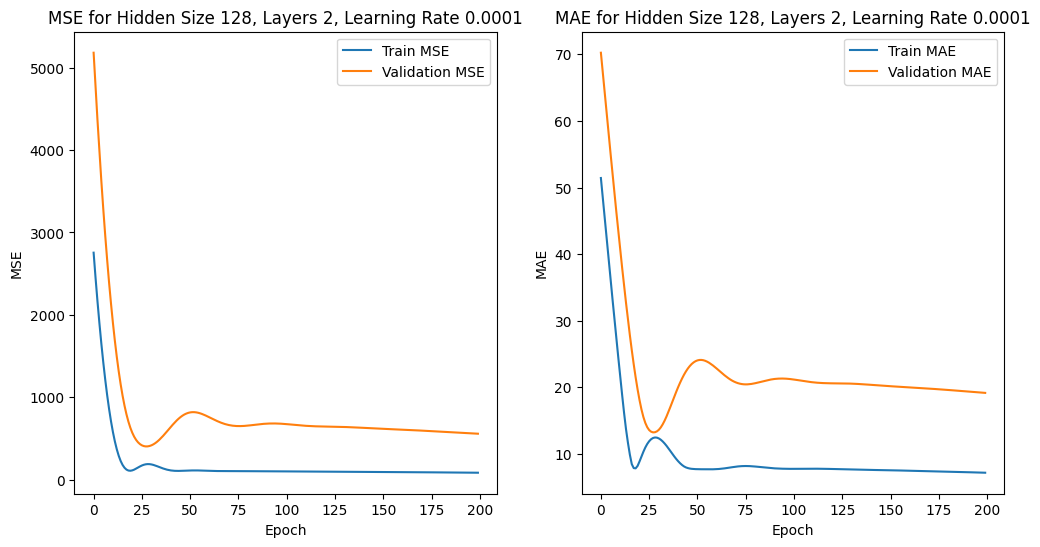

In [25]:
# Plot training and validation losses
plt.figure(figsize=(12, 6))

# Plot MSE
plt.subplot(1, 2, 1)
plt.plot(train_mse_vals, label='Train MSE')
plt.plot(val_mse_vals, label='Validation MSE')
plt.title(f'MSE for Hidden Size {hidden_size}, Layers {num_layers}, Learning Rate {learning_rate}')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(train_mae_vals, label='Train MAE')
plt.plot(val_mae_vals, label='Validation MAE')
plt.title(f'MAE for Hidden Size {hidden_size}, Layers {num_layers}, Learning Rate {learning_rate}')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.show()

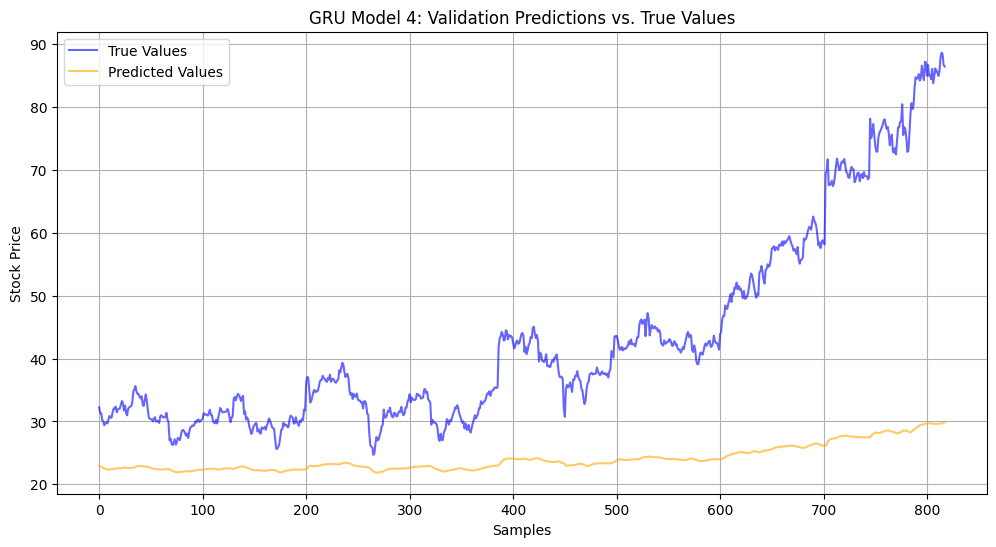

In [26]:
plot_full_validation_predictions(modelGRU4, X_val, y_val, scaler, model_name="GRU Model 4")

### GRU Model 5, increasing sequence length

In [27]:
# Increase sequence length for this experiment
seq_length = 60  # Increased sequence length
print(f"Experimenting with Sequence Length: {seq_length}, Hidden Size: 128, Layers: 2, Learning Rate: 0.0001")

# Create new sequences with the increased sequence length
X, y = create_sequences(data_normalized, seq_length=seq_length)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)  
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.3, shuffle=False) 
X_train, y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32)
X_val, y_val = torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32)
X_train, y_train = X_train.to(device), y_train.to(device)
X_val, y_val = X_val.to(device), y_val.to(device)

# Initialize the GRU model
modelGRU5 = StockPriceRNN(
    input_size=input_size,
    hidden_size=128,  # Hidden size remains the same
    num_layers=2,  # Number of layers remains the same
    output_size=output_size,
    rnn_type="GRU"
).to(device)

# Loss functions and optimizer
criterion_mse = nn.MSELoss()
criterion_mae = nn.L1Loss()
optimizer = optim.Adam(modelGRU5.parameters(), lr=0.0001)  # Keep learning rate from the previous experiment


Experimenting with Sequence Length: 60, Hidden Size: 128, Layers: 2, Learning Rate: 0.0001


In [28]:
# Track training and validation losses
train_mse_vals, train_mae_vals = [], []  # Lists to store training losses
val_mse_vals, val_mae_vals = [], []  # Lists to store validation losses

# Initialize variables for best validation MSE tracking
best_val_mse = float('inf')  # Start with a very high MSE value
best_model_path = "best_modelGRU4.pth"  # Path to save the best model
best_epoch = -1  # Variable to store the epoch of the best model
best_val_mae = None  # Variable to store the corresponding MAE of the best model

# Training loop
for epoch in range(num_epochs):
    # Training phase
    modelGRU5.train()
    optimizer.zero_grad()
    outputs = modelGRU5(X_train)
    train_loss_mse = criterion_mse(outputs, y_train)
    train_loss_mae = criterion_mae(outputs, y_train)
    train_loss_mse.backward()
    optimizer.step()

    # Inverse scaling for training metrics
    outputs_original = scaler.inverse_transform(outputs.detach().cpu().numpy())
    y_train_original = scaler.inverse_transform(y_train.cpu().numpy())

    train_mse_original = ((outputs_original - y_train_original) ** 2).mean()
    train_mae_original = abs(outputs_original - y_train_original).mean()

    # Record training losses
    train_mse_vals.append(train_mse_original)
    train_mae_vals.append(train_mae_original)

    # Validation phase
    modelGRU5.eval()
    with torch.no_grad():
        val_outputs = modelGRU5(X_val)
        val_loss_mse = criterion_mse(val_outputs, y_val)
        val_loss_mae = criterion_mae(val_outputs, y_val)

        # Inverse scaling for validation metrics
        val_outputs_original = scaler.inverse_transform(val_outputs.cpu().numpy())
        y_val_original = scaler.inverse_transform(y_val.cpu().numpy())

        val_mse_original = ((val_outputs_original - y_val_original) ** 2).mean()
        val_mae_original = abs(val_outputs_original - y_val_original).mean()

        # Record validation losses
        val_mse_vals.append(val_mse_original)
        val_mae_vals.append(val_mae_original)

        # Save the model if validation MSE improves
        if val_mse_original < best_val_mse:
            best_val_mse = val_mse_original
            best_epoch = epoch + 1
            best_val_mae = val_mae_original
            torch.save(modelGRU5.state_dict(), best_model_path)
            

In [29]:
print(f"Best Model Saved at Epoch {best_epoch}, with Validation MSE: {best_val_mse:.6f}, "
      f"and Validation MAE: {best_val_mae:.6f}")

Best Model Saved at Epoch 163, with Validation MSE: 4.079564, and Validation MAE: 1.506956


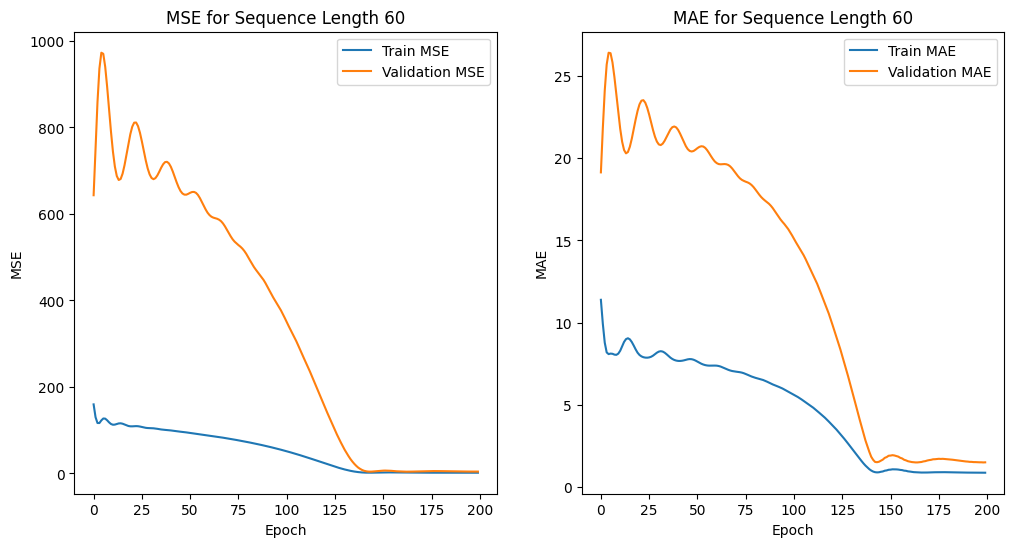

In [30]:
# Plot training and validation losses
plt.figure(figsize=(12, 6))

# Plot MSE
plt.subplot(1, 2, 1)
plt.plot(train_mse_vals, label='Train MSE')
plt.plot(val_mse_vals, label='Validation MSE')
plt.title(f'MSE for Sequence Length {seq_length}')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(train_mae_vals, label='Train MAE')
plt.plot(val_mae_vals, label='Validation MAE')
plt.title(f'MAE for Sequence Length {seq_length}')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.show()

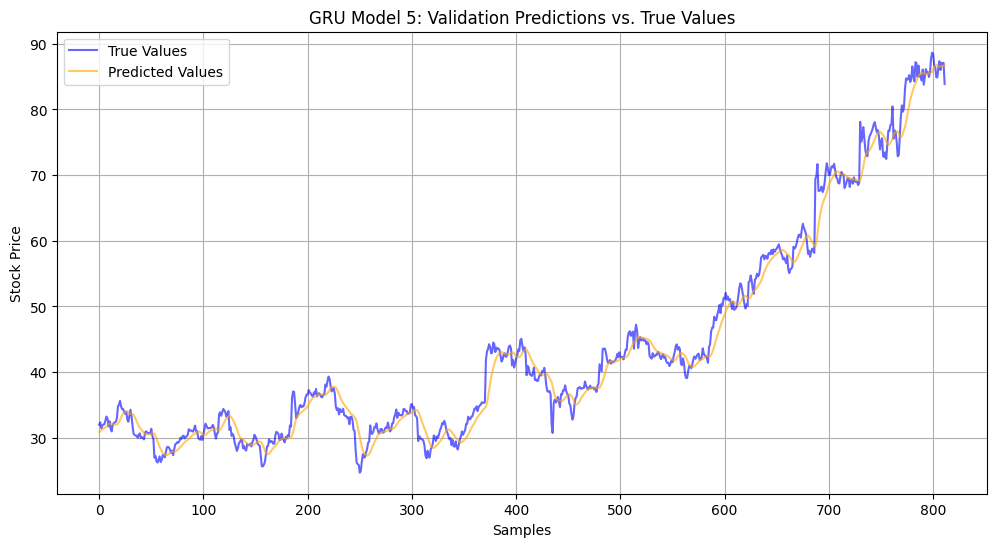

In [31]:
plot_full_validation_predictions(modelGRU5, X_val, y_val, scaler, model_name="GRU Model 5")

### GRU model 6, increase batch size to 64 and epochs to 200

In [32]:
from torch.utils.data import DataLoader, TensorDataset

# Parameters for this experiment
seq_length = 50  # Keep sequence length from previous experiment
batch_size = 64  # Increase batch size
num_epochs = 300  # Increase number of epochs
print(f"Experimenting with Batch Size: {batch_size}, Epochs: {num_epochs}, Sequence Length: {seq_length}")

# Create new sequences with the increased sequence length
X, y = create_sequences(data_normalized, seq_length=seq_length)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)  
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.3, shuffle=False) 

# Convert data to tensors
X_train, y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32)
X_val, y_val = torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32)
X_train, y_train = X_train.to(device), y_train.to(device)
X_val, y_val = X_val.to(device), y_val.to(device)

# Create DataLoader for batching
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Initialize the GRU model
modelGRU6 = StockPriceRNN(
    input_size=input_size,
    hidden_size=128,  # Hidden size remains the same
    num_layers=2,  # Number of layers remains the same
    output_size=output_size,
    rnn_type="GRU"
).to(device)

# Loss functions and optimizer
criterion_mse = nn.MSELoss()
criterion_mae = nn.L1Loss()
optimizer = optim.Adam(modelGRU6.parameters(), lr=0.0001)


Experimenting with Batch Size: 64, Epochs: 300, Sequence Length: 50


In [33]:
# Track training and validation losses
train_mse_vals, train_mae_vals = [], []  # Lists to store training losses
val_mse_vals, val_mae_vals = [], []  # Lists to store validation losses

# Initialize variables for best validation MSE tracking
best_val_mse = float('inf')  # Start with a very high MSE value
best_model_path = "best_modelGRU6.pth"  # Path to save the best model
best_epoch = -1  # Variable to store the epoch of the best model
best_val_mae = None  # Variable to store the corresponding MAE of the best model

# Training loop
for epoch in range(num_epochs):
    # Training phase
    modelGRU6.train()
    epoch_train_mse, epoch_train_mae = 0.0, 0.0
    epoch_train_original_mse, epoch_train_original_mae = 0.0, 0.0  # For original-scale metrics
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = modelGRU6(X_batch)
        loss_mse = criterion_mse(outputs, y_batch)
        loss_mae = criterion_mae(outputs, y_batch)
        loss_mse.backward()
        optimizer.step()
        epoch_train_mse += loss_mse.item() * len(X_batch)
        epoch_train_mae += loss_mae.item() * len(X_batch)

        # Compute original-scale metrics
        outputs_original = scaler.inverse_transform(outputs.detach().cpu().numpy())
        y_batch_original = scaler.inverse_transform(y_batch.cpu().numpy())
        epoch_train_original_mse += ((outputs_original - y_batch_original) ** 2).sum()
        epoch_train_original_mae += abs(outputs_original - y_batch_original).sum()

    train_mse_vals.append(epoch_train_original_mse / len(train_loader.dataset))
    train_mae_vals.append(epoch_train_original_mae / len(train_loader.dataset))

    # Validation phase
    modelGRU6.eval()
    epoch_val_mse, epoch_val_mae = 0.0, 0.0
    epoch_val_original_mse, epoch_val_original_mae = 0.0, 0.0  # For original-scale metrics
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            val_outputs = modelGRU6(X_batch)
            loss_mse = criterion_mse(val_outputs, y_batch)
            loss_mae = criterion_mae(val_outputs, y_batch)
            epoch_val_mse += loss_mse.item() * len(X_batch)
            epoch_val_mae += loss_mae.item() * len(X_batch)

            # Compute original-scale metrics
            val_outputs_original = scaler.inverse_transform(val_outputs.cpu().numpy())
            y_batch_original = scaler.inverse_transform(y_batch.cpu().numpy())
            epoch_val_original_mse += ((val_outputs_original - y_batch_original) ** 2).sum()
            epoch_val_original_mae += abs(val_outputs_original - y_batch_original).sum()

    val_mse_vals.append(epoch_val_original_mse / len(val_loader.dataset))
    val_mae_vals.append(epoch_val_original_mae / len(val_loader.dataset))

    # Save the model if validation MSE improves
    if val_mse_vals[-1] < best_val_mse:
        best_val_mse = val_mse_vals[-1]
        best_epoch = epoch + 1
        best_val_mae = val_mae_vals[-1]
        torch.save(modelGRU6.state_dict(), best_model_path)

    # Print loss information every 50 epochs or at the first epoch
    if (epoch + 1) % 50 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train MSE : {train_mse_vals[-1]:.4f}, Val MSE : {val_mse_vals[-1]:.4f}, "
              f"Train MAE : {train_mae_vals[-1]:.4f}, Val MAE : {val_mae_vals[-1]:.4f}")


Epoch [1/300], Train MSE : 113.6671, Val MSE : 741.0985, Train MAE : 8.4288, Val MAE : 22.4949
Epoch [50/300], Train MSE : 1.2110, Val MSE : 3.3895, Train MAE : 0.7748, Val MAE : 1.3173
Epoch [100/300], Train MSE : 1.0331, Val MSE : 2.3972, Train MAE : 0.7497, Val MAE : 1.0712
Epoch [150/300], Train MSE : 0.7273, Val MSE : 2.4918, Train MAE : 0.6051, Val MAE : 1.1299
Epoch [200/300], Train MSE : 0.6776, Val MSE : 2.2737, Train MAE : 0.5940, Val MAE : 1.0686
Epoch [250/300], Train MSE : 0.5543, Val MSE : 1.5066, Train MAE : 0.5252, Val MAE : 0.8187
Epoch [300/300], Train MSE : 0.4626, Val MSE : 1.4929, Train MAE : 0.4680, Val MAE : 0.8170


In [34]:
print(f"Best Model Saved at Epoch {best_epoch}, with Validation MSE: {best_val_mse:.6f}, "
      f"and Validation MAE: {best_val_mae:.6f}")

Best Model Saved at Epoch 296, with Validation MSE: 1.416763, and Validation MAE: 0.786120


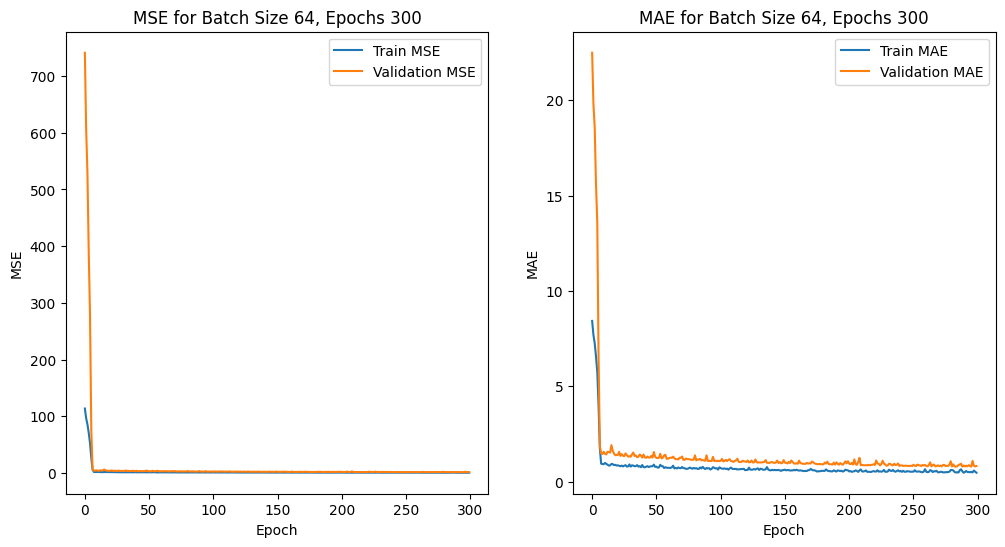

In [35]:
# Plot training and validation losses
plt.figure(figsize=(12, 6))

# Plot MSE
plt.subplot(1, 2, 1)
plt.plot(train_mse_vals, label='Train MSE')
plt.plot(val_mse_vals, label='Validation MSE')
plt.title(f'MSE for Batch Size {batch_size}, Epochs {num_epochs}')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(train_mae_vals, label='Train MAE')
plt.plot(val_mae_vals, label='Validation MAE')
plt.title(f'MAE for Batch Size {batch_size}, Epochs {num_epochs}')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.show()

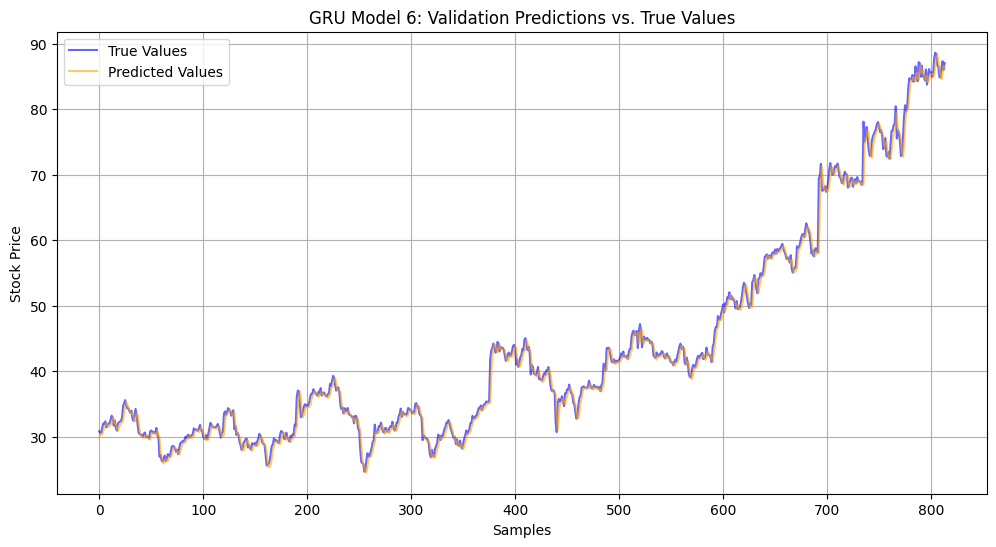

In [36]:
plot_full_validation_predictions(modelGRU6, X_val, y_val, scaler, model_name="GRU Model 6")

# LSTM

In [37]:
# Specify the type of RNN
rnn_type = "LSTM"  # Choose between "LSTM", "GRU", and "RNN"
num_epochs = 200
# Initialize the second model
modelLSTM = StockPriceRNN(input_size, hidden_size, num_layers, output_size, rnn_type).to('cuda' if torch.cuda.is_available() else 'cpu')

# Define the loss functions and optimizer
criterion_mse = nn.MSELoss()  # Mean Squared Error loss
criterion_mae = nn.L1Loss()  # Mean Absolute Error loss
optimizer = optim.Adam(modelLSTM.parameters(), lr=learning_rate)  # Adam optimizer with specified learning rate

# Ensure training and validation data are on the same device as the model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
X_train, y_train = X_train.to(device), y_train.to(device)
X_val, y_val = X_val.to(device), y_val.to(device)



In [38]:
# Initialize lists to track training and validation losses
train_mse_vals, train_mae_vals = [], []  # Lists to store training losses
val_mse_vals, val_mae_vals = [], []  # Lists to store validation losses

# Initialize variables for best validation MSE tracking
best_val_mse = float('inf')  # Start with a very high MSE value
best_model_path = "best_modelLSTM.pth"  # Path to save the best model
best_epoch = -1  # Variable to store the epoch of the best model
best_val_mae = None  # Variable to store the corresponding MAE of the best model

# Training loop
for epoch in range(num_epochs):
    # Training phase
    modelLSTM.train()  # Set model to training mode
    optimizer.zero_grad()  # Clear previous gradients
    outputs = modelLSTM(X_train)  # Forward pass on training data
    train_loss_mse = criterion_mse(outputs, y_train)  # Compute training MSE loss
    train_loss_mae = criterion_mae(outputs, y_train)  # Compute training MAE loss
    train_loss_mse.backward()  # Backpropagation
    optimizer.step()  # Update model weights

    # Inverse scaling to compute original-scale training MSE and MAE
    outputs_original = scaler.inverse_transform(outputs.detach().cpu().numpy())  # Convert predictions to original scale
    y_train_original = scaler.inverse_transform(y_train.cpu().numpy())  # Convert target values to original scale

    train_mse_original = ((outputs_original - y_train_original) ** 2).mean()
    train_mae_original = abs(outputs_original - y_train_original).mean()

    # Record training losses
    train_mse_vals.append(train_mse_original)
    train_mae_vals.append(train_mae_original)

    # Validation phase
    modelLSTM.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Disable gradient computation for validation
        val_outputs = modelLSTM(X_val)  # Forward pass on validation data
        val_loss_mse = criterion_mse(val_outputs, y_val)  # Validation MSE loss
        val_loss_mae = criterion_mae(val_outputs, y_val)  # Validation MAE loss

        # Inverse scaling to compute original-scale validation MSE and MAE
        val_outputs_original = scaler.inverse_transform(val_outputs.cpu().numpy())  # Convert predictions to original scale
        y_val_original = scaler.inverse_transform(y_val.cpu().numpy())  # Convert target values to original scale

        val_mse_original = ((val_outputs_original - y_val_original) ** 2).mean()
        val_mae_original = abs(val_outputs_original - y_val_original).mean()

        # Record validation losses
        val_mse_vals.append(val_mse_original)
        val_mae_vals.append(val_mae_original)

        # Save the model if validation MSE improves
        if val_mse_original < best_val_mse:
            best_val_mse = val_mse_original
            best_epoch = epoch + 1
            best_val_mae = val_mae_original
            torch.save(modelLSTM.state_dict(), best_model_path)
            print(f"Epoch {best_epoch}: Validation MSE improved to {best_val_mse:.4f}, "
                  f"Validation MAE: {best_val_mae:.4f}, model saved!")

    # Print loss information for the epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train MSE : {train_mse_original:.4f}, Val MSE : {val_mse_original:.4f}, '
          f'Train MAE : {train_mae_original:.4f}, Val MAE : {val_mae_original:.4f}')


Epoch 1: Validation MSE improved to 598.6981, Validation MAE: 18.3604, model saved!
Epoch [1/200], Train MSE : 140.5288, Val MSE : 598.6981, Train MAE : 10.5928, Val MAE : 18.3604
Epoch [2/200], Train MSE : 127.4867, Val MSE : 649.5953, Train MAE : 9.8859, Val MAE : 19.7002
Epoch [3/200], Train MSE : 118.3219, Val MSE : 701.6843, Train MAE : 9.2470, Val MAE : 20.9850
Epoch [4/200], Train MSE : 112.9538, Val MSE : 752.6262, Train MAE : 8.7073, Val MAE : 22.1701
Epoch [5/200], Train MSE : 110.9501, Val MSE : 798.6319, Train MAE : 8.2951, Val MAE : 23.1893
Epoch [6/200], Train MSE : 111.4908, Val MSE : 835.7240, Train MAE : 8.0651, Val MAE : 23.9807
Epoch [7/200], Train MSE : 113.3501, Val MSE : 860.7346, Train MAE : 7.9605, Val MAE : 24.5016
Epoch [8/200], Train MSE : 115.2547, Val MSE : 872.7739, Train MAE : 7.9225, Val MAE : 24.7510
Epoch [9/200], Train MSE : 116.3384, Val MSE : 873.1713, Train MAE : 7.9117, Val MAE : 24.7637
Epoch [10/200], Train MSE : 116.3489, Val MSE : 864.1367, Tr

In [39]:
print(f"Best Model Saved at Epoch {best_epoch}, with Validation MSE: {best_val_mse:.6f}, "
      f"and Validation MAE: {best_val_mae:.6f}")

Best Model Saved at Epoch 145, with Validation MSE: 7.485833, and Validation MAE: 2.131706


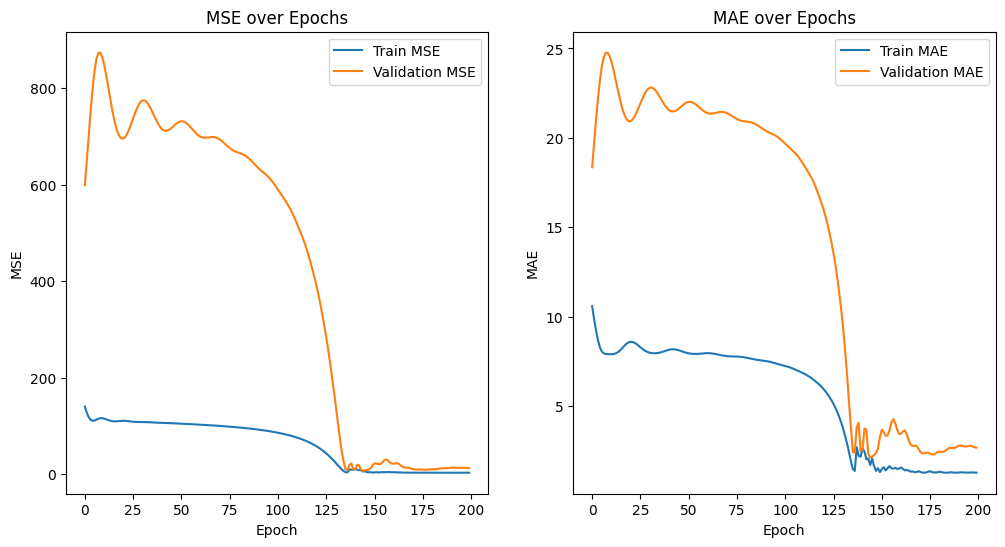

In [40]:
# Plot training and validation losses over epochs
plt.figure(figsize=(12, 6))

# Plot MSE
plt.subplot(1, 2, 1)
plt.plot(train_mse_vals, label='Train MSE')  # Plot training MSE
plt.plot(val_mse_vals, label='Validation MSE')  # Plot validation MSE
plt.title('MSE over Epochs')  # Title for the MSE plot
plt.xlabel('Epoch')  # X-axis label
plt.ylabel('MSE')  # Y-axis label
plt.legend()  # Display legend

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(train_mae_vals, label='Train MAE')  # Plot training MAE
plt.plot(val_mae_vals, label='Validation MAE')  # Plot validation MAE
plt.title('MAE over Epochs')  # Title for the MAE plot
plt.xlabel('Epoch')  # X-axis label
plt.ylabel('MAE')  # Y-axis label
plt.legend()  # Display legend

# Show plots
plt.show()

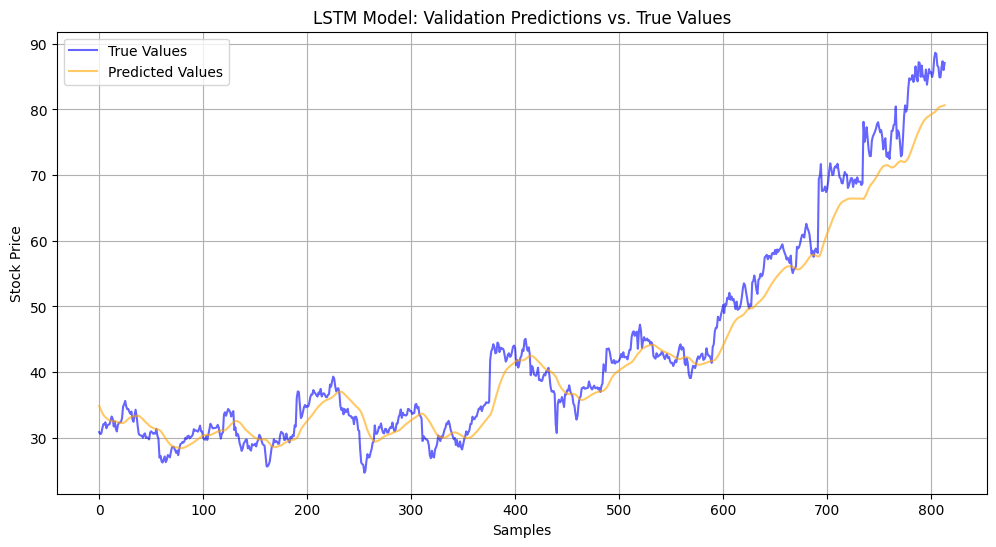

In [41]:
plot_full_validation_predictions(modelLSTM, X_val, y_val, scaler, model_name="LSTM Model")

### LSTM model 2, increase hidden unit to 128

In [42]:
# Define the LSTM model with a hidden size of 128
hidden_size = 128  # Set the hidden size for this experiment

print(f"Experimenting with LSTM - Hidden Size: {hidden_size}")
# Initialize the LSTM model
modelLSTM2 = StockPriceRNN(
    input_size=input_size,
    hidden_size=hidden_size,
    num_layers=num_layers,  # Keep layers constant for now
    output_size=output_size,
    rnn_type="LSTM"  # Specify LSTM
).to(device)

# Loss functions and optimizer
criterion_mse = nn.MSELoss()
criterion_mae = nn.L1Loss()
optimizer = optim.Adam(modelLSTM2.parameters(), lr=learning_rate)


Experimenting with LSTM - Hidden Size: 128


In [43]:
# Track training and validation losses
train_mse_vals, train_mae_vals = [], []  # Lists to store training losses
val_mse_vals, val_mae_vals = [], []  # Lists to store validation losses

# Initialize variables for best validation MSE tracking
best_val_mse = float('inf')  # Start with a very high MSE value
best_model_path = "best_modelLSTM2.pth"  # Path to save the best model
best_epoch = -1  # Variable to store the epoch of the best model
best_val_mae = None  # Variable to store the corresponding MAE of the best model

# Training loop
for epoch in range(num_epochs):
    # Training phase
    modelLSTM2.train()
    optimizer.zero_grad()
    outputs = modelLSTM2(X_train)
    train_loss_mse = criterion_mse(outputs, y_train)
    train_loss_mae = criterion_mae(outputs, y_train)
    train_loss_mse.backward()
    optimizer.step()

    # Inverse scaling for training metrics
    outputs_original = scaler.inverse_transform(outputs.detach().cpu().numpy())  # Convert predictions to original scale
    y_train_original = scaler.inverse_transform(y_train.cpu().numpy())  # Convert target values to original scale

    train_mse_original = ((outputs_original - y_train_original) ** 2).mean()
    train_mae_original = abs(outputs_original - y_train_original).mean()

    # Record training losses
    train_mse_vals.append(train_mse_original)
    train_mae_vals.append(train_mae_original)

    # Validation phase
    modelLSTM2.eval()
    with torch.no_grad():
        val_outputs = modelLSTM2(X_val)
        val_loss_mse = criterion_mse(val_outputs, y_val)
        val_loss_mae = criterion_mae(val_outputs, y_val)

        # Inverse scaling for validation metrics
        val_outputs_original = scaler.inverse_transform(val_outputs.cpu().numpy())  # Convert predictions to original scale
        y_val_original = scaler.inverse_transform(y_val.cpu().numpy())  # Convert target values to original scale

        val_mse_original = ((val_outputs_original - y_val_original) ** 2).mean()
        val_mae_original = abs(val_outputs_original - y_val_original).mean()

        # Record validation losses
        val_mse_vals.append(val_mse_original)
        val_mae_vals.append(val_mae_original)

        # Save the model if validation MSE improves
        if val_mse_original < best_val_mse:
            best_val_mse = val_mse_original
            best_epoch = epoch + 1
            best_val_mae = val_mae_original
            torch.save(modelLSTM2.state_dict(), best_model_path)
            

In [44]:
print(f"Best Model Saved at Epoch {best_epoch}, with Validation MSE: {best_val_mse:.6f}, "
      f"and Validation MAE: {best_val_mae:.6f}")

Best Model Saved at Epoch 180, with Validation MSE: 7.082099, and Validation MAE: 2.090762


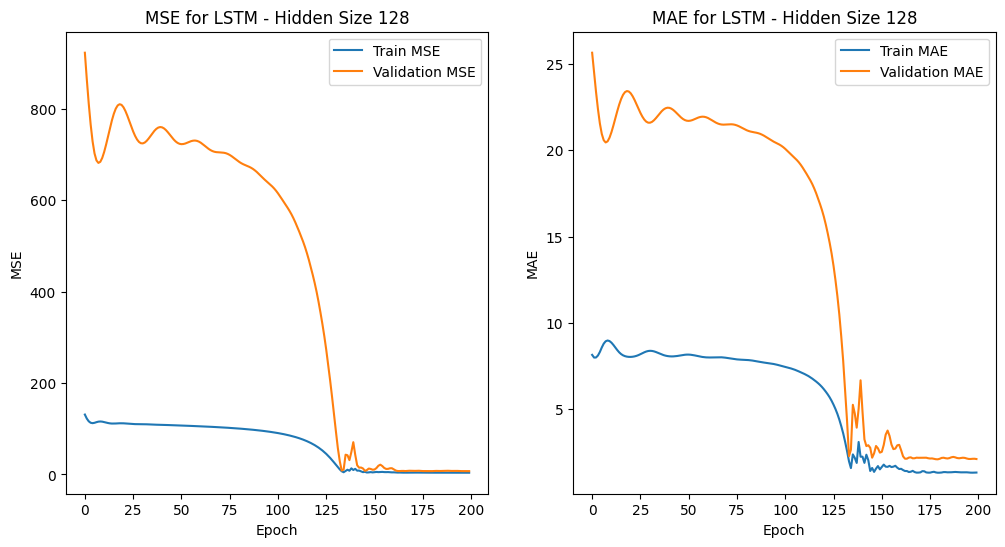

In [45]:
# Plot training and validation losses
plt.figure(figsize=(12, 6))

# Plot MSE
plt.subplot(1, 2, 1)
plt.plot(train_mse_vals, label='Train MSE')
plt.plot(val_mse_vals, label='Validation MSE')
plt.title(f'MSE for LSTM - Hidden Size {hidden_size}')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(train_mae_vals, label='Train MAE')
plt.plot(val_mae_vals, label='Validation MAE')
plt.title(f'MAE for LSTM - Hidden Size {hidden_size}')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.show()

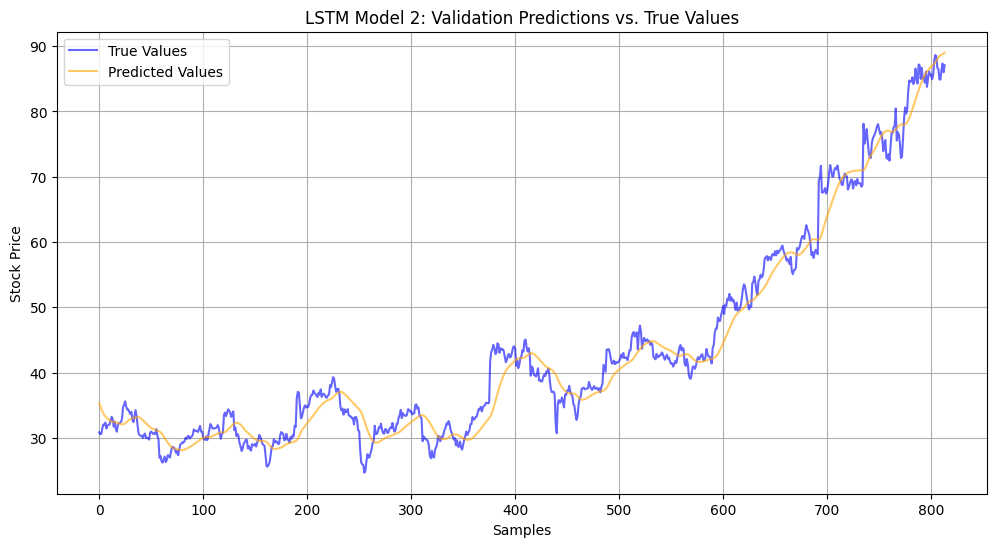

In [46]:
plot_full_validation_predictions(modelLSTM2, X_val, y_val, scaler, model_name="LSTM Model 2")

### LSTM Model 3, adding multiple layers

In [47]:
# Define the LSTM model with multiple layers (e.g., 2 layers)
hidden_size = 128  # Keep the hidden size constant
num_layers = 2  # Set the number of LSTM layers for this experiment

print(f"Experimenting with LSTM - Hidden Size: {hidden_size}, Number of Layers: {num_layers}")
# Initialize the LSTM model
modelLSTM3 = StockPriceRNN(
    input_size=input_size,
    hidden_size=hidden_size,
    num_layers=num_layers,  # Set multiple layers
    output_size=output_size,
    rnn_type="LSTM"
).to(device)

# Loss functions and optimizer
criterion_mse = nn.MSELoss()
criterion_mae = nn.L1Loss()
optimizer = optim.Adam(modelLSTM3.parameters(), lr=learning_rate)


Experimenting with LSTM - Hidden Size: 128, Number of Layers: 2


In [48]:
# Track training and validation losses
train_mse_vals, train_mae_vals = [], []  # Lists to store training losses
val_mse_vals, val_mae_vals = [], []  # Lists to store validation losses

# Initialize variables for best validation MSE tracking
best_val_mse = float('inf')  # Start with a very high MSE value
best_model_path = "best_modelLSTM3.pth"  # Path to save the best model
best_epoch = -1  # Variable to store the epoch of the best model
best_val_mae = None  # Variable to store the corresponding MAE of the best model

# Training loop
for epoch in range(num_epochs):
    # Training phase
    modelLSTM3.train()
    optimizer.zero_grad()
    outputs = modelLSTM3(X_train)
    train_loss_mse = criterion_mse(outputs, y_train)
    train_loss_mae = criterion_mae(outputs, y_train)
    train_loss_mse.backward()
    optimizer.step()

    # Inverse scaling to compute original-scale training MSE and MAE
    outputs_original = scaler.inverse_transform(outputs.detach().cpu().numpy())  # Convert predictions to original scale
    y_train_original = scaler.inverse_transform(y_train.cpu().numpy())  # Convert target values to original scale

    train_mse_original = ((outputs_original - y_train_original) ** 2).mean()
    train_mae_original = abs(outputs_original - y_train_original).mean()

    # Record training losses
    train_mse_vals.append(train_mse_original)
    train_mae_vals.append(train_mae_original)

    # Validation phase
    modelLSTM3.eval()
    with torch.no_grad():
        val_outputs = modelLSTM3(X_val)
        val_loss_mse = criterion_mse(val_outputs, y_val)
        val_loss_mae = criterion_mae(val_outputs, y_val)

        # Inverse scaling to compute original-scale validation MSE and MAE
        val_outputs_original = scaler.inverse_transform(val_outputs.cpu().numpy())  # Convert predictions to original scale
        y_val_original = scaler.inverse_transform(y_val.cpu().numpy())  # Convert target values to original scale

        val_mse_original = ((val_outputs_original - y_val_original) ** 2).mean()
        val_mae_original = abs(val_outputs_original - y_val_original).mean()

        # Record validation losses
        val_mse_vals.append(val_mse_original)
        val_mae_vals.append(val_mae_original)

        # Save the model if validation MSE improves
        if val_mse_original < best_val_mse:
            best_val_mse = val_mse_original
            best_epoch = epoch + 1
            best_val_mae = val_mae_original
            torch.save(modelLSTM3.state_dict(), best_model_path)
            

In [49]:
print(f"Best Model Saved at Epoch {best_epoch}, with Validation MSE: {best_val_mse:.6f}, "
      f"and Validation MAE: {best_val_mae:.6f}")

Best Model Saved at Epoch 45, with Validation MSE: 561.826599, and Validation MAE: 17.414078


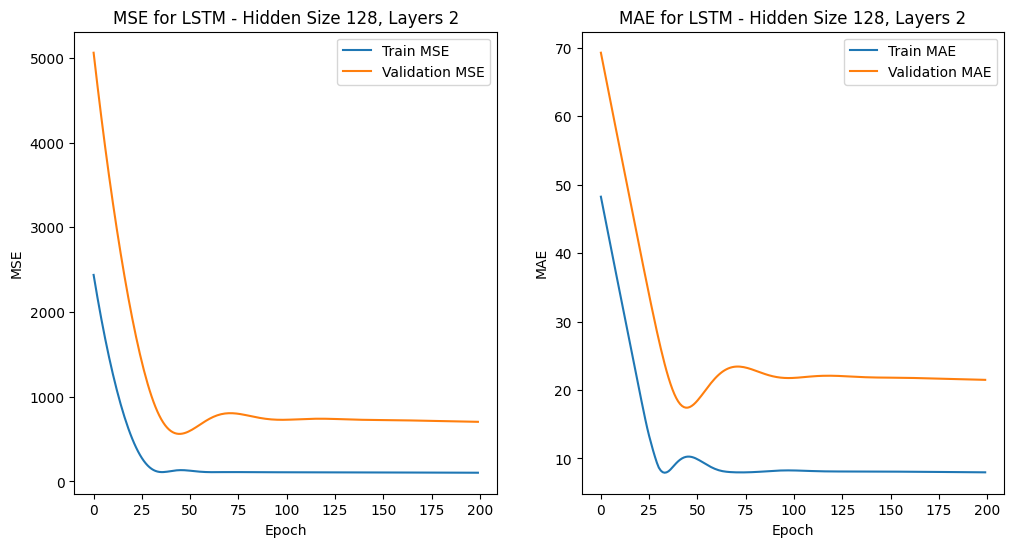

In [50]:
# Plot training and validation losses
plt.figure(figsize=(12, 6))

# Plot MSE
plt.subplot(1, 2, 1)
plt.plot(train_mse_vals, label='Train MSE')
plt.plot(val_mse_vals, label='Validation MSE')
plt.title(f'MSE for LSTM - Hidden Size {hidden_size}, Layers {num_layers}')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(train_mae_vals, label='Train MAE')
plt.plot(val_mae_vals, label='Validation MAE')
plt.title(f'MAE for LSTM - Hidden Size {hidden_size}, Layers {num_layers}')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.show()

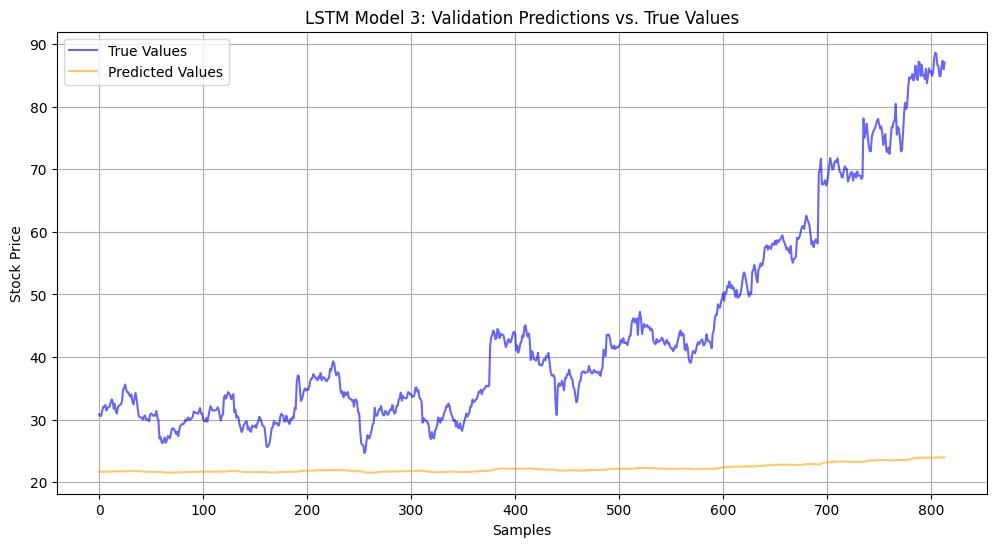

In [51]:
plot_full_validation_predictions(modelLSTM3, X_val, y_val, scaler, model_name="LSTM Model 3")

### LSTM model 4, decreasing learning rate to 0.0001

In [52]:
# Define the LSTM model with decreased learning rate
hidden_size = 128  # Keep the hidden size constant
num_layers = 2  # Keep the number of layers constant
learning_rate = 0.0001  # Decrease the learning rate for this experiment

print(f"Experimenting with LSTM - Hidden Size: {hidden_size}, Layers: {num_layers}, Learning Rate: {learning_rate}")
# Initialize the LSTM model
modelLSTM4 = StockPriceRNN(
    input_size=input_size,
    hidden_size=hidden_size,
    num_layers=num_layers,
    output_size=output_size,
    rnn_type="LSTM"
).to(device)

# Loss functions and optimizer
criterion_mse = nn.MSELoss()
criterion_mae = nn.L1Loss()
optimizer = optim.Adam(modelLSTM4.parameters(), lr=learning_rate)


Experimenting with LSTM - Hidden Size: 128, Layers: 2, Learning Rate: 0.0001


In [53]:
# Track training and validation losses
train_mse_vals, train_mae_vals = [], []  # Lists to store training losses
val_mse_vals, val_mae_vals = [], []  # Lists to store validation losses

# Initialize variables for best validation MSE tracking
best_val_mse = float('inf')  # Start with a very high MSE value
best_model_path = "best_modelLSTM4.pth"  # Path to save the best model
best_epoch = -1  # Variable to store the epoch of the best model
best_val_mae = None  # Variable to store the corresponding MAE of the best model

# Training loop
for epoch in range(num_epochs):
    # Training phase
    modelLSTM4.train()
    optimizer.zero_grad()
    outputs = modelLSTM4(X_train)
    train_loss_mse = criterion_mse(outputs, y_train)
    train_loss_mae = criterion_mae(outputs, y_train)
    train_loss_mse.backward()
    optimizer.step()

    # Inverse scaling to compute original-scale training MSE and MAE
    outputs_original = scaler.inverse_transform(outputs.detach().cpu().numpy())  # Convert predictions to original scale
    y_train_original = scaler.inverse_transform(y_train.cpu().numpy())  # Convert target values to original scale

    train_mse_original = ((outputs_original - y_train_original) ** 2).mean()
    train_mae_original = abs(outputs_original - y_train_original).mean()

    # Record training losses
    train_mse_vals.append(train_mse_original)
    train_mae_vals.append(train_mae_original)

    # Validation phase
    modelLSTM4.eval()
    with torch.no_grad():
        val_outputs = modelLSTM4(X_val)
        val_loss_mse = criterion_mse(val_outputs, y_val)
        val_loss_mae = criterion_mae(val_outputs, y_val)

        # Inverse scaling to compute original-scale validation MSE and MAE
        val_outputs_original = scaler.inverse_transform(val_outputs.cpu().numpy())  # Convert predictions to original scale
        y_val_original = scaler.inverse_transform(y_val.cpu().numpy())  # Convert target values to original scale

        val_mse_original = ((val_outputs_original - y_val_original) ** 2).mean()
        val_mae_original = abs(val_outputs_original - y_val_original).mean()

        # Record validation losses
        val_mse_vals.append(val_mse_original)
        val_mae_vals.append(val_mae_original)

        # Save the model if validation MSE improves
        if val_mse_original < best_val_mse:
            best_val_mse = val_mse_original
            best_epoch = epoch + 1
            best_val_mae = val_mae_original
            torch.save(modelLSTM4.state_dict(), best_model_path)
           

In [54]:
print(f"Best Model Saved at Epoch {best_epoch}, with Validation MSE: {best_val_mse:.6f}, "
      f"and Validation MAE: {best_val_mae:.6f}")

Best Model Saved at Epoch 135, with Validation MSE: 6.752887, and Validation MAE: 2.034480


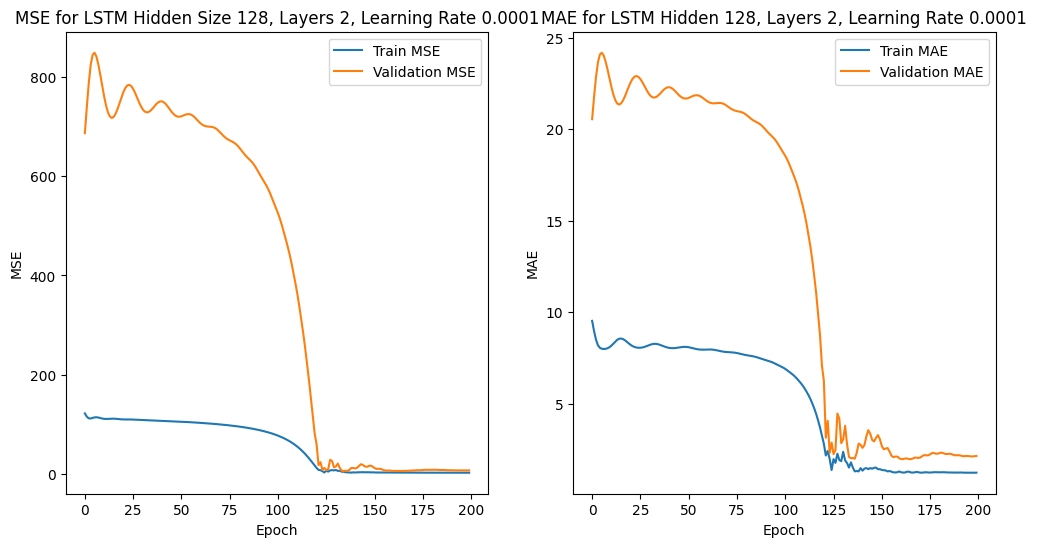

In [55]:
# Plot training and validation losses
plt.figure(figsize=(12, 6))

# Plot MSE
plt.subplot(1, 2, 1)
plt.plot(train_mse_vals, label='Train MSE')
plt.plot(val_mse_vals, label='Validation MSE')
plt.title(f'MSE for LSTM Hidden Size {hidden_size}, Layers {num_layers}, Learning Rate {learning_rate}')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(train_mae_vals, label='Train MAE')
plt.plot(val_mae_vals, label='Validation MAE')
plt.title(f'MAE for LSTM Hidden {hidden_size}, Layers {num_layers}, Learning Rate {learning_rate}')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.show()

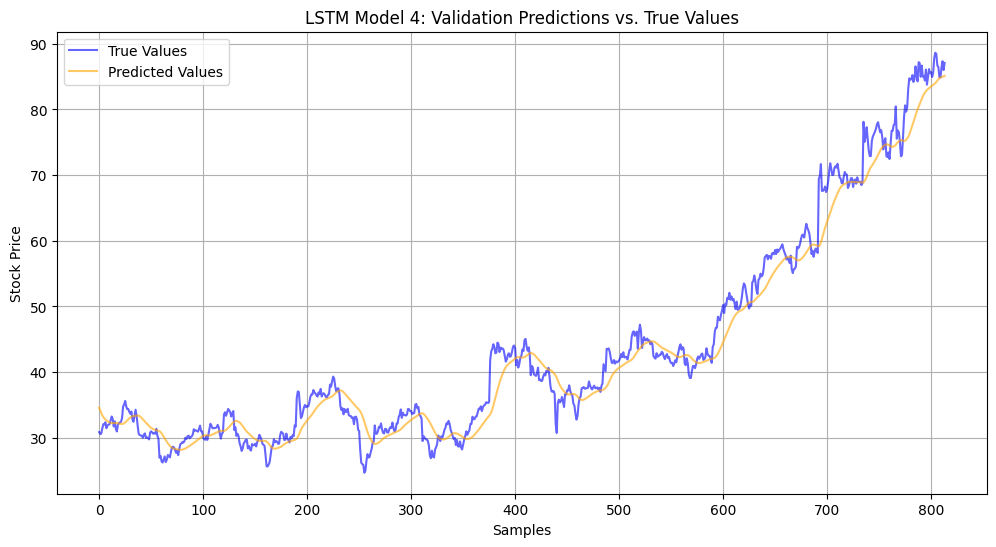

In [56]:
plot_full_validation_predictions(modelLSTM4, X_val, y_val, scaler, model_name="LSTM Model 4")

### model 5, increase sequence length to 60

In [57]:
# Increase sequence length for this experiment
seq_length = 60  # Increased sequence length
print(f"Experimenting with LSTM - Sequence Length: {seq_length}, Hidden Size: 128, Layers: 2, Learning Rate: 0.0001")

# Create new sequences with the increased sequence length
X, y = create_sequences(data_normalized, seq_length=seq_length)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)  
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.3, shuffle=False) 

# Convert data to tensors
X_train, y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32)
X_val, y_val = torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32)
X_train, y_train = X_train.to(device), y_train.to(device)
X_val, y_val = X_val.to(device), y_val.to(device)

# Initialize the LSTM model
modelLSTM5 = StockPriceRNN(
    input_size=input_size,
    hidden_size=128,  # Hidden size remains the same
    num_layers=2,  # Number of layers remains the same
    output_size=output_size,
    rnn_type="LSTM"
).to(device)

# Loss functions and optimizer
criterion_mse = nn.MSELoss()
criterion_mae = nn.L1Loss()
optimizer = optim.Adam(modelLSTM5.parameters(), lr=0.0001)  # Keep learning rate from the previous experiment


Experimenting with LSTM - Sequence Length: 60, Hidden Size: 128, Layers: 2, Learning Rate: 0.0001


In [58]:
# Track training and validation losses
train_mse_vals, train_mae_vals = [], []  # Lists to store training losses
val_mse_vals, val_mae_vals = [], []  # Lists to store validation losses

# Initialize variables for best validation MSE tracking
best_val_mse = float('inf')  # Start with a very high MSE value
best_model_path = "best_modelLSTM5.pth"  # Path to save the best model
best_epoch = -1  # Variable to store the epoch of the best model
best_val_mae = None  # Variable to store the corresponding MAE of the best model

# Training loop
for epoch in range(num_epochs):
    # Training phase
    modelLSTM5.train()
    optimizer.zero_grad()
    outputs = modelLSTM5(X_train)
    train_loss_mse = criterion_mse(outputs, y_train)
    train_loss_mae = criterion_mae(outputs, y_train)
    train_loss_mse.backward()
    optimizer.step()

    # Inverse scaling to compute original-scale training MSE and MAE
    outputs_original = scaler.inverse_transform(outputs.detach().cpu().numpy())  # Convert predictions to original scale
    y_train_original = scaler.inverse_transform(y_train.cpu().numpy())  # Convert target values to original scale

    train_mse_original = ((outputs_original - y_train_original) ** 2).mean()
    train_mae_original = abs(outputs_original - y_train_original).mean()

    # Record training losses
    train_mse_vals.append(train_mse_original)
    train_mae_vals.append(train_mae_original)

    # Validation phase
    modelLSTM5.eval()
    with torch.no_grad():
        val_outputs = modelLSTM5(X_val)
        val_loss_mse = criterion_mse(val_outputs, y_val)
        val_loss_mae = criterion_mae(val_outputs, y_val)

        # Inverse scaling to compute original-scale validation MSE and MAE
        val_outputs_original = scaler.inverse_transform(val_outputs.cpu().numpy())  # Convert predictions to original scale
        y_val_original = scaler.inverse_transform(y_val.cpu().numpy())  # Convert target values to original scale

        val_mse_original = ((val_outputs_original - y_val_original) ** 2).mean()
        val_mae_original = abs(val_outputs_original - y_val_original).mean()

        # Record validation losses
        val_mse_vals.append(val_mse_original)
        val_mae_vals.append(val_mae_original)

        # Save the model if validation MSE improves
        if val_mse_original < best_val_mse:
            best_val_mse = val_mse_original
            best_epoch = epoch + 1
            best_val_mae = val_mae_original
            torch.save(modelLSTM5.state_dict(), best_model_path)
           

In [59]:
print(f"Best Model Saved at Epoch {best_epoch}, with Validation MSE: {best_val_mse:.6f}, "
      f"and Validation MAE: {best_val_mae:.6f}")

Best Model Saved at Epoch 46, with Validation MSE: 577.529114, and Validation MAE: 17.879435


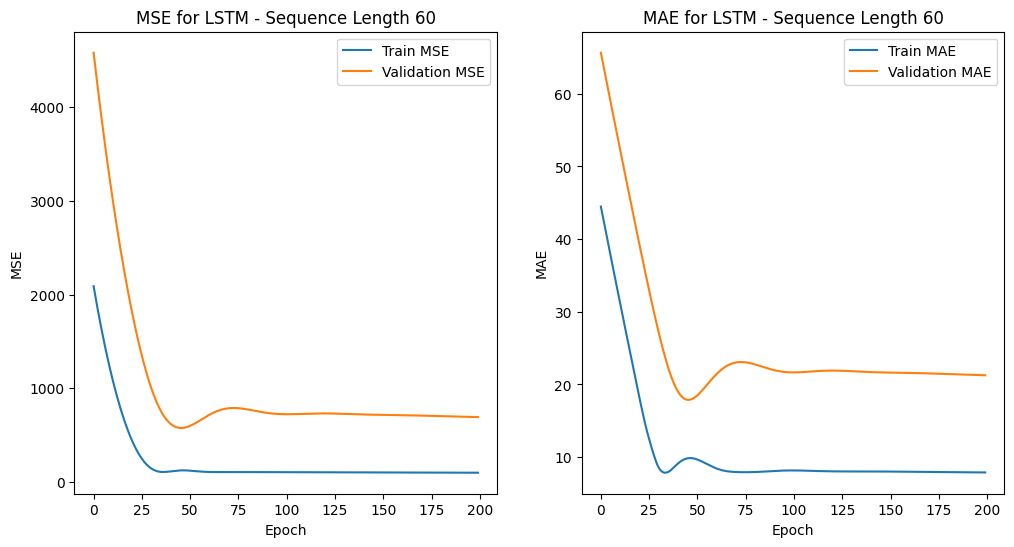

In [60]:
# Plot training and validation losses
plt.figure(figsize=(12, 6))

# Plot MSE
plt.subplot(1, 2, 1)
plt.plot(train_mse_vals, label='Train MSE')
plt.plot(val_mse_vals, label='Validation MSE')
plt.title(f'MSE for LSTM - Sequence Length {seq_length}')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(train_mae_vals, label='Train MAE')
plt.plot(val_mae_vals, label='Validation MAE')
plt.title(f'MAE for LSTM - Sequence Length {seq_length}')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.show()

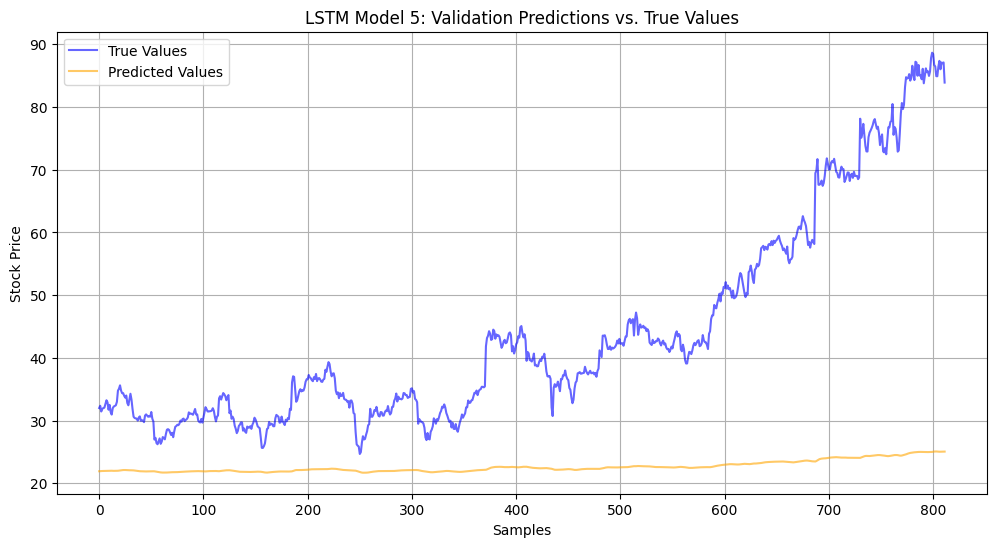

In [61]:
plot_full_validation_predictions(modelLSTM5, X_val, y_val, scaler, model_name="LSTM Model 5")

### model 6, increase batch size and epochs

In [62]:
from torch.utils.data import DataLoader, TensorDataset

# Parameters for this experiment
seq_length = 50  # Keep sequence length from the previous experiment
batch_size = 64  # Increase batch size
num_epochs = 300  # Increase number of epochs
print(f"Experimenting with LSTM - Batch Size: {batch_size}, Epochs: {num_epochs}, Sequence Length: {seq_length}")

# Create new sequences with the increased sequence length
X, y = create_sequences(data_normalized, seq_length=seq_length)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)  
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.3, shuffle=False) 

# Convert data to tensors
X_train, y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32)
X_val, y_val = torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32)
X_train, y_train = X_train.to(device), y_train.to(device)
X_val, y_val = X_val.to(device), y_val.to(device)

# Create DataLoader for batching
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Initialize the LSTM model
modelLSTM6 = StockPriceRNN(
    input_size=input_size,
    hidden_size=128,  # Hidden size remains the same
    num_layers=2,  # Number of layers remains the same
    output_size=output_size,
    rnn_type="LSTM"
).to(device)

# Loss functions and optimizer
criterion_mse = nn.MSELoss()
criterion_mae = nn.L1Loss()
optimizer = optim.Adam(modelLSTM6.parameters(), lr=0.0001)


Experimenting with LSTM - Batch Size: 64, Epochs: 300, Sequence Length: 50


In [63]:
# Track training and validation losses
train_mse_vals, train_mae_vals = [], []  # Lists to store training losses
val_mse_vals, val_mae_vals = [], []  # Lists to store validation losses

# Initialize variables for best validation MSE tracking
best_val_mse = float('inf')  # Start with a very high MSE value
best_model_path = "best_modelLSTM6.pth"  # Path to save the best model
best_epoch = -1  # Variable to store the epoch of the best model
best_val_mae = None  # Variable to store the corresponding MAE of the best model

# Training loop
for epoch in range(num_epochs):
    # Training phase
    modelLSTM6.train()
    epoch_train_mse, epoch_train_mae = 0.0, 0.0
    epoch_train_original_mse, epoch_train_original_mae = 0.0, 0.0  # For original-scale metrics
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = modelLSTM6(X_batch)
        loss_mse = criterion_mse(outputs, y_batch)
        loss_mae = criterion_mae(outputs, y_batch)
        loss_mse.backward()
        optimizer.step()
        epoch_train_mse += loss_mse.item() * len(X_batch)
        epoch_train_mae += loss_mae.item() * len(X_batch)

        # Compute original-scale metrics
        outputs_original = scaler.inverse_transform(outputs.detach().cpu().numpy())
        y_batch_original = scaler.inverse_transform(y_batch.cpu().numpy())
        epoch_train_original_mse += ((outputs_original - y_batch_original) ** 2).sum()
        epoch_train_original_mae += abs(outputs_original - y_batch_original).sum()

    train_mse_vals.append(epoch_train_original_mse / len(train_loader.dataset))
    train_mae_vals.append(epoch_train_original_mae / len(train_loader.dataset))

    # Validation phase
    modelLSTM6.eval()
    epoch_val_mse, epoch_val_mae = 0.0, 0.0
    epoch_val_original_mse, epoch_val_original_mae = 0.0, 0.0  # For original-scale metrics
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            val_outputs = modelLSTM6(X_batch)
            loss_mse = criterion_mse(val_outputs, y_batch)
            loss_mae = criterion_mae(val_outputs, y_batch)
            epoch_val_mse += loss_mse.item() * len(X_batch)
            epoch_val_mae += loss_mae.item() * len(X_batch)

            # Compute original-scale metrics
            val_outputs_original = scaler.inverse_transform(val_outputs.cpu().numpy())
            y_batch_original = scaler.inverse_transform(y_batch.cpu().numpy())
            epoch_val_original_mse += ((val_outputs_original - y_batch_original) ** 2).sum()
            epoch_val_original_mae += abs(val_outputs_original - y_batch_original).sum()

    val_mse_vals.append(epoch_val_original_mse / len(val_loader.dataset))
    val_mae_vals.append(epoch_val_original_mae / len(val_loader.dataset))

    # Save the model if validation MSE improves
    if val_mse_vals[-1] < best_val_mse:
        best_val_mse = val_mse_vals[-1]
        best_epoch = epoch + 1
        best_val_mae = val_mae_vals[-1]
        torch.save(modelLSTM6.state_dict(), best_model_path)
        print(f"Epoch {best_epoch}: Validation MSE improved to {best_val_mse:.4f}, "
              f"Validation MAE: {best_val_mae:.4f}, model saved!")

    # Print loss information every 50 epochs or at the first epoch
    if (epoch + 1) % 50 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train MSE : {train_mse_vals[-1]:.4f}, Val MSE : {val_mse_vals[-1]:.4f}, "
              f"Train MAE : {train_mae_vals[-1]:.4f}, Val MAE : {val_mae_vals[-1]:.4f}")


Epoch 1: Validation MSE improved to 615.2589, Validation MAE: 18.7502, model saved!
Epoch [1/300], Train MSE : 226.4285, Val MSE : 615.2589, Train MAE : 11.7603, Val MAE : 18.7502
Epoch 8: Validation MSE improved to 577.2683, Validation MAE: 19.2615, model saved!
Epoch 9: Validation MSE improved to 482.4661, Validation MAE: 17.9828, model saved!
Epoch 10: Validation MSE improved to 9.6677, Validation MAE: 2.4465, model saved!
Epoch 13: Validation MSE improved to 8.1672, Validation MAE: 2.1853, model saved!
Epoch 14: Validation MSE improved to 7.7487, Validation MAE: 2.1329, model saved!
Epoch 17: Validation MSE improved to 6.4208, Validation MAE: 1.9645, model saved!
Epoch 27: Validation MSE improved to 6.2929, Validation MAE: 1.8730, model saved!
Epoch 45: Validation MSE improved to 5.8072, Validation MAE: 1.7728, model saved!
Epoch [50/300], Train MSE : 2.7441, Val MSE : 6.8032, Train MAE : 1.2155, Val MAE : 1.9472
Epoch 55: Validation MSE improved to 5.3722, Validation MAE: 1.6930, 

In [64]:
print(f"Best Model Saved at Epoch {best_epoch}, with Validation MSE: {best_val_mse:.6f}, "
      f"and Validation MAE: {best_val_mae:.6f}")

Best Model Saved at Epoch 298, with Validation MSE: 2.590556, and Validation MAE: 1.103391


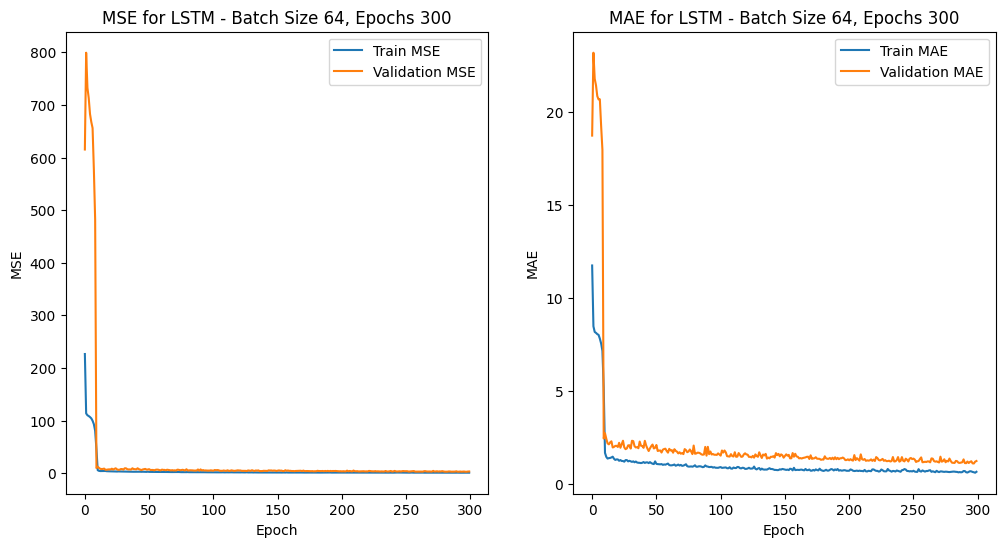

In [65]:
# Plot training and validation losses
plt.figure(figsize=(12, 6))

# Plot MSE
plt.subplot(1, 2, 1)
plt.plot(train_mse_vals, label='Train MSE')
plt.plot(val_mse_vals, label='Validation MSE')
plt.title(f'MSE for LSTM - Batch Size {batch_size}, Epochs {num_epochs}')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(train_mae_vals, label='Train MAE')
plt.plot(val_mae_vals, label='Validation MAE')
plt.title(f'MAE for LSTM - Batch Size {batch_size}, Epochs {num_epochs}')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.show()

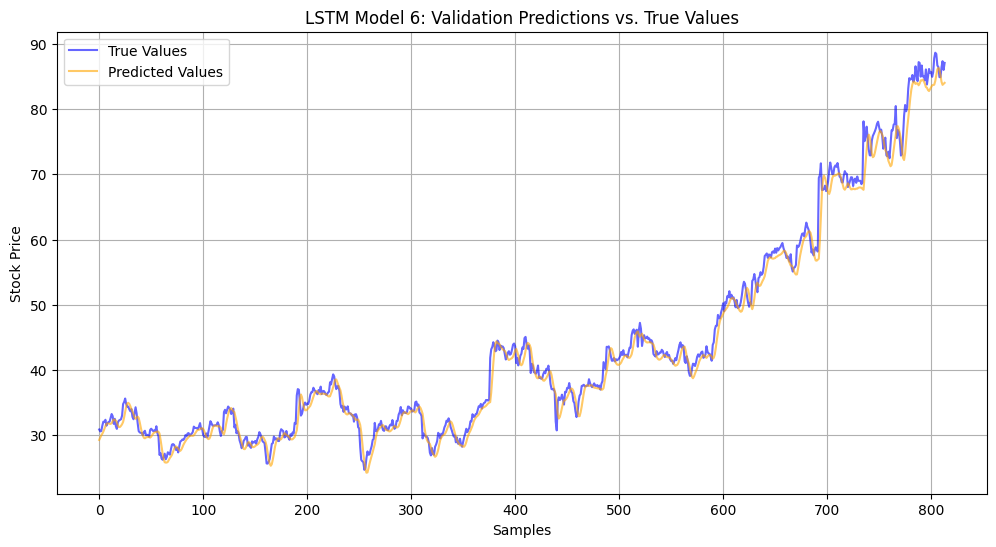

In [66]:
plot_full_validation_predictions(modelLSTM6, X_val, y_val, scaler, model_name="LSTM Model 6")

# RNN

In [67]:
# Specify the RNN type
rnn_type = "RNN"  # Choose between "LSTM", "GRU", and "RNN"
num_epochs = 200
# Initialize the third model
modelRNN = StockPriceRNN(input_size, hidden_size, num_layers, output_size, rnn_type).to('cuda' if torch.cuda.is_available() else 'cpu')

# Define the loss functions and optimizer
criterion_mse = nn.MSELoss()  # Mean Squared Error loss
criterion_mae = nn.L1Loss()  # Mean Absolute Error loss
optimizer = optim.Adam(modelRNN.parameters(), lr=learning_rate)  # Adam optimizer with specified learning rate

# Ensure training and validation data are on the same device as the model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
X_train, y_train = X_train.to(device), y_train.to(device)
X_val, y_val = X_val.to(device), y_val.to(device)


In [68]:
# Initialize lists to track training and validation losses
train_mse_vals, train_mae_vals = [], []  # Lists to store training losses
val_mse_vals, val_mae_vals = [], []  # Lists to store validation losses

# Initialize variables for best validation MSE tracking
best_val_mse = float('inf')  # Start with a very high MSE value
best_model_path = "best_modelRNN.pth"  # Path to save the best model
best_epoch = -1  # Variable to store the epoch of the best model
best_val_mae = None  # Variable to store the corresponding MAE of the best model

# Training loop
for epoch in range(num_epochs):
    # Training phase
    modelRNN.train()
    optimizer.zero_grad()
    outputs = modelRNN(X_train)
    train_loss_mse = criterion_mse(outputs, y_train)
    train_loss_mae = criterion_mae(outputs, y_train)
    train_loss_mse.backward()
    optimizer.step()

    # Inverse scaling for training metrics
    outputs_original = scaler.inverse_transform(outputs.detach().cpu().numpy())
    y_train_original = scaler.inverse_transform(y_train.cpu().numpy())

    train_mse_original = ((outputs_original - y_train_original) ** 2).mean()
    train_mae_original = abs(outputs_original - y_train_original).mean()

    # Record training losses
    train_mse_vals.append(train_mse_original)
    train_mae_vals.append(train_mae_original)

    # Validation phase
    modelRNN.eval()
    with torch.no_grad():
        val_outputs = modelRNN(X_val)
        val_loss_mse = criterion_mse(val_outputs, y_val)
        val_loss_mae = criterion_mae(val_outputs, y_val)

        # Inverse scaling for validation metrics
        val_outputs_original = scaler.inverse_transform(val_outputs.cpu().numpy())
        y_val_original = scaler.inverse_transform(y_val.cpu().numpy())

        val_mse_original = ((val_outputs_original - y_val_original) ** 2).mean()
        val_mae_original = abs(val_outputs_original - y_val_original).mean()

        # Record validation losses
        val_mse_vals.append(val_mse_original)
        val_mae_vals.append(val_mae_original)

        # Save the model if validation MSE improves
        if val_mse_original < best_val_mse:
            best_val_mse = val_mse_original
            best_epoch = epoch + 1
            best_val_mae = val_mae_original
            torch.save(modelRNN.state_dict(), best_model_path)
            print(f"Epoch {best_epoch}: Validation MSE improved to {best_val_mse:.4f}, "
                  f"Validation MAE: {best_val_mae:.4f}, model saved!")

    # Print loss information for the epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train MSE: {train_loss_mse.item():.4f}, Val MSE: {val_loss_mse.item():.4f}, '
          f'Train MAE: {train_loss_mae.item():.4f}, Val MAE: {val_loss_mae.item():.4f}')


Epoch 1: Validation MSE improved to 3377.1758, Validation MAE: 55.8520, model saved!
Epoch [1/200], Train MSE: 0.0170, Val MSE: 0.0339, Train MAE: 0.1260, Val MAE: 0.1770
Epoch 2: Validation MSE improved to 2730.6272, Validation MAE: 49.7344, model saved!
Epoch [2/200], Train MSE: 0.0124, Val MSE: 0.0274, Train MAE: 0.1065, Val MAE: 0.1576
Epoch 3: Validation MSE improved to 2165.3867, Validation MAE: 43.6908, model saved!
Epoch [3/200], Train MSE: 0.0087, Val MSE: 0.0217, Train MAE: 0.0872, Val MAE: 0.1384
Epoch 4: Validation MSE improved to 1681.4745, Validation MAE: 37.7574, model saved!
Epoch [4/200], Train MSE: 0.0057, Val MSE: 0.0169, Train MAE: 0.0682, Val MAE: 0.1196
Epoch 5: Validation MSE improved to 1279.9424, Validation MAE: 32.0117, model saved!
Epoch [5/200], Train MSE: 0.0035, Val MSE: 0.0128, Train MAE: 0.0497, Val MAE: 0.1014
Epoch 6: Validation MSE improved to 958.4724, Validation MAE: 26.5322, model saved!
Epoch [6/200], Train MSE: 0.0021, Val MSE: 0.0096, Train MAE:

In [69]:
print(f"Best Model Saved at Epoch {best_epoch}, with Validation MSE: {best_val_mse:.6f}, "
      f"and Validation MAE: {best_val_mae:.6f}")

Best Model Saved at Epoch 191, with Validation MSE: 4.570542, and Validation MAE: 1.604003


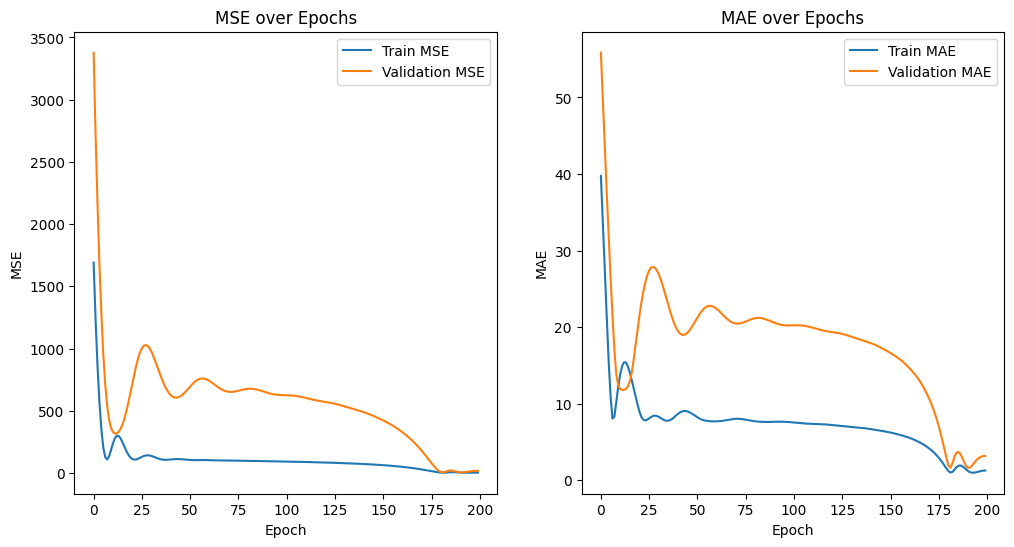

In [70]:
# Plot training and validation losses over epochs
plt.figure(figsize=(12, 6))

# Plot MSE
plt.subplot(1, 2, 1)
plt.plot(train_mse_vals, label='Train MSE')  # Plot training MSE
plt.plot(val_mse_vals, label='Validation MSE')  # Plot validation MSE
plt.title('MSE over Epochs')  # Title for the MSE plot
plt.xlabel('Epoch')  # X-axis label
plt.ylabel('MSE')  # Y-axis label
plt.legend()  # Display legend

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(train_mae_vals, label='Train MAE')  # Plot training MAE
plt.plot(val_mae_vals, label='Validation MAE')  # Plot validation MAE
plt.title('MAE over Epochs')  # Title for the MAE plot
plt.xlabel('Epoch')  # X-axis label
plt.ylabel('MAE')  # Y-axis label
plt.legend()  # Display legend

# Show plots
plt.show()

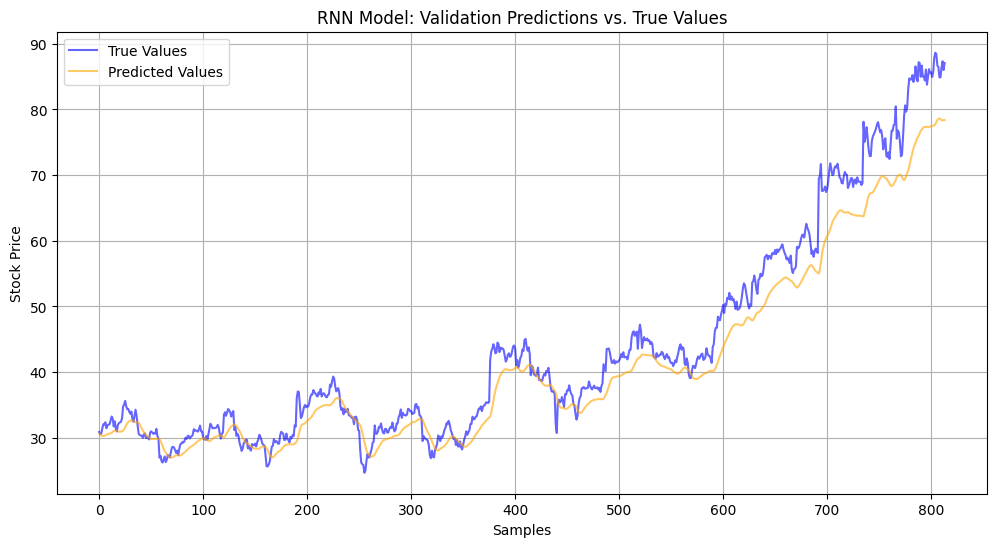

In [71]:
plot_full_validation_predictions(modelRNN, X_val, y_val, scaler, model_name="RNN Model")

### RNN model 2, increase hidden size to 128

In [72]:
# Define the RNN model with a hidden size of 128
hidden_size = 128  # Set the hidden size for this experiment

print(f"Experimenting with RNN - Hidden Size: {hidden_size}")
# Initialize the RNN model
modelRNN2 = StockPriceRNN(
    input_size=input_size,
    hidden_size=hidden_size,
    num_layers=num_layers,  # Keep layers constant for now
    output_size=output_size,
    rnn_type="RNN"  # Specify RNN
).to(device)

# Loss functions and optimizer
criterion_mse = nn.MSELoss()
criterion_mae = nn.L1Loss()
optimizer = optim.Adam(modelRNN2.parameters(), lr=learning_rate)


Experimenting with RNN - Hidden Size: 128


In [73]:
# Track training and validation losses
train_mse_vals, train_mae_vals = [], []  # Lists to store training losses
val_mse_vals, val_mae_vals = [], []  # Lists to store validation losses

# Initialize variables for best validation MSE tracking
best_val_mse = float('inf')  # Start with a very high MSE value
best_model_path = "best_modelRNN2.pth"  # Path to save the best model
best_epoch = -1  # Variable to store the epoch of the best model
best_val_mae = None  # Variable to store the corresponding MAE of the best model

# Training loop
for epoch in range(num_epochs):
    # Training phase
    modelRNN2.train()
    optimizer.zero_grad()
    outputs = modelRNN2(X_train)
    train_loss_mse = criterion_mse(outputs, y_train)
    train_loss_mae = criterion_mae(outputs, y_train)
    train_loss_mse.backward()
    optimizer.step()

    # Inverse scaling for training metrics
    outputs_original = scaler.inverse_transform(outputs.detach().cpu().numpy())
    y_train_original = scaler.inverse_transform(y_train.cpu().numpy())

    train_mse_original = ((outputs_original - y_train_original) ** 2).mean()
    train_mae_original = abs(outputs_original - y_train_original).mean()

    # Record training losses
    train_mse_vals.append(train_mse_original)
    train_mae_vals.append(train_mae_original)

    # Validation phase
    modelRNN2.eval()
    with torch.no_grad():
        val_outputs = modelRNN2(X_val)
        val_loss_mse = criterion_mse(val_outputs, y_val)
        val_loss_mae = criterion_mae(val_outputs, y_val)

        # Inverse scaling for validation metrics
        val_outputs_original = scaler.inverse_transform(val_outputs.cpu().numpy())
        y_val_original = scaler.inverse_transform(y_val.cpu().numpy())

        val_mse_original = ((val_outputs_original - y_val_original) ** 2).mean()
        val_mae_original = abs(val_outputs_original - y_val_original).mean()

        # Record validation losses
        val_mse_vals.append(val_mse_original)
        val_mae_vals.append(val_mae_original)

        # Save the model if validation MSE improves
        if val_mse_original < best_val_mse:
            best_val_mse = val_mse_original
            best_epoch = epoch + 1
            best_val_mae = val_mae_original
            torch.save(modelRNN2.state_dict(), best_model_path)

In [74]:
print(f"Best Model Saved at Epoch {best_epoch}, with Validation MSE: {best_val_mse:.6f}, "
      f"and Validation MAE: {best_val_mae:.6f}")

Best Model Saved at Epoch 142, with Validation MSE: 3.755842, and Validation MAE: 1.390512


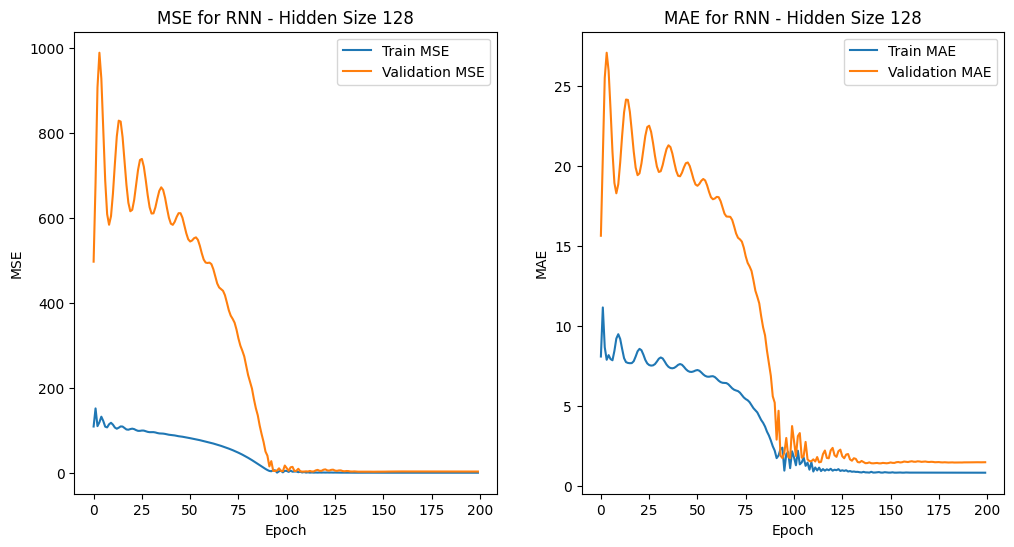

In [75]:
# Plot training and validation losses
plt.figure(figsize=(12, 6))

# Plot MSE
plt.subplot(1, 2, 1)
plt.plot(train_mse_vals, label='Train MSE')
plt.plot(val_mse_vals, label='Validation MSE')
plt.title(f'MSE for RNN - Hidden Size {hidden_size}')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(train_mae_vals, label='Train MAE')
plt.plot(val_mae_vals, label='Validation MAE')
plt.title(f'MAE for RNN - Hidden Size {hidden_size}')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.show()

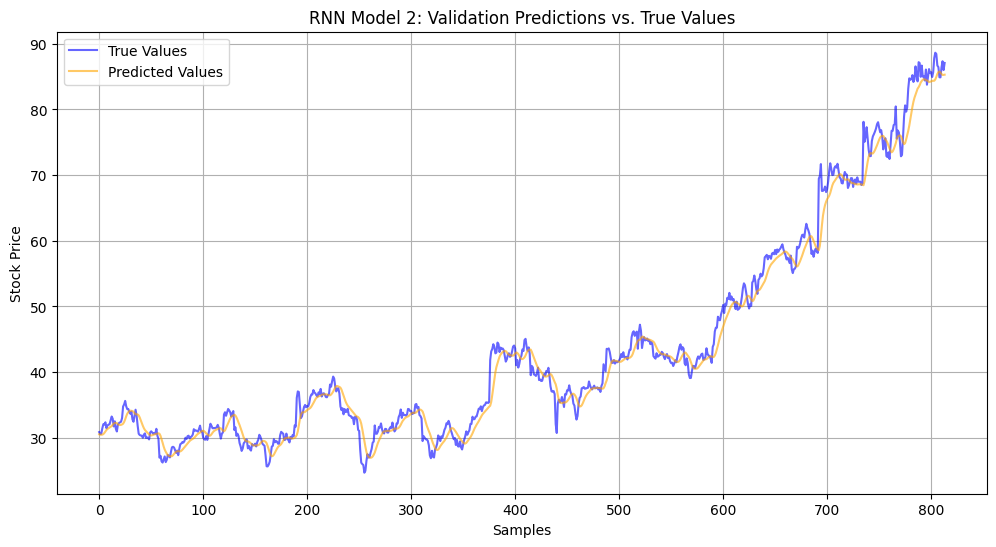

In [76]:
plot_full_validation_predictions(modelRNN2, X_val, y_val, scaler, model_name="RNN Model 2")

### RNN model 3, multiple layers RNN

In [77]:
# Define the RNN model with multiple layers (e.g., 2 layers)
hidden_size = 128  # Keep the hidden size constant
num_layers = 2  # Set the number of RNN layers for this experiment

print(f"Experimenting with RNN - Hidden Size: {hidden_size}, Number of Layers: {num_layers}")
# Initialize the RNN model
modelRNN3 = StockPriceRNN(
    input_size=input_size,
    hidden_size=hidden_size,
    num_layers=num_layers,  # Set multiple layers
    output_size=output_size,
    rnn_type="RNN"
).to(device)

# Loss functions and optimizer
criterion_mse = nn.MSELoss()
criterion_mae = nn.L1Loss()
optimizer = optim.Adam(modelRNN3.parameters(), lr=learning_rate)


Experimenting with RNN - Hidden Size: 128, Number of Layers: 2


In [78]:
# Track training and validation losses
train_mse_vals, train_mae_vals = [], []  # Lists to store training losses
val_mse_vals, val_mae_vals = [], []  # Lists to store validation losses

# Initialize variables for best validation MSE tracking
best_val_mse = float('inf')  # Start with a very high MSE value
best_model_path = "best_modelRNN3.pth"  # Path to save the best model
best_epoch = -1  # Variable to store the epoch of the best model
best_val_mae = None  # Variable to store the corresponding MAE of the best model

# Training loop
for epoch in range(num_epochs):
    # Training phase
    modelRNN3.train()
    optimizer.zero_grad()
    outputs = modelRNN3(X_train)
    train_loss_mse = criterion_mse(outputs, y_train)
    train_loss_mae = criterion_mae(outputs, y_train)
    train_loss_mse.backward()
    optimizer.step()

    # Inverse scaling for training metrics
    outputs_original = scaler.inverse_transform(outputs.detach().cpu().numpy())
    y_train_original = scaler.inverse_transform(y_train.cpu().numpy())

    train_mse_original = ((outputs_original - y_train_original) ** 2).mean()
    train_mae_original = abs(outputs_original - y_train_original).mean()

    # Record training losses
    train_mse_vals.append(train_mse_original)
    train_mae_vals.append(train_mae_original)

    # Validation phase
    modelRNN3.eval()
    with torch.no_grad():
        val_outputs = modelRNN3(X_val)
        val_loss_mse = criterion_mse(val_outputs, y_val)
        val_loss_mae = criterion_mae(val_outputs, y_val)

        # Inverse scaling for validation metrics
        val_outputs_original = scaler.inverse_transform(val_outputs.cpu().numpy())
        y_val_original = scaler.inverse_transform(y_val.cpu().numpy())

        val_mse_original = ((val_outputs_original - y_val_original) ** 2).mean()
        val_mae_original = abs(val_outputs_original - y_val_original).mean()

        # Record validation losses
        val_mse_vals.append(val_mse_original)
        val_mae_vals.append(val_mae_original)

        # Save the model if validation MSE improves
        if val_mse_original < best_val_mse:
            best_val_mse = val_mse_original
            best_epoch = epoch + 1
            best_val_mae = val_mae_original
            torch.save(modelRNN3.state_dict(), best_model_path)


In [79]:
print(f"Best Model Saved at Epoch {best_epoch}, with Validation MSE: {best_val_mse:.6f}, "
      f"and Validation MAE: {best_val_mae:.6f}")

Best Model Saved at Epoch 173, with Validation MSE: 4.420590, and Validation MAE: 1.566453


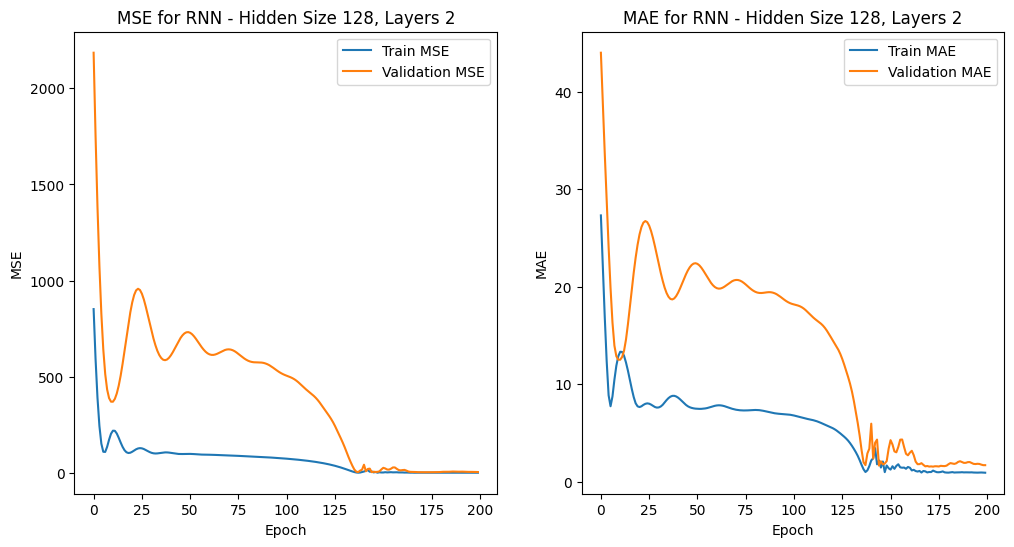

In [80]:
# Plot training and validation losses
plt.figure(figsize=(12, 6))

# Plot MSE
plt.subplot(1, 2, 1)
plt.plot(train_mse_vals, label='Train MSE')
plt.plot(val_mse_vals, label='Validation MSE')
plt.title(f'MSE for RNN - Hidden Size {hidden_size}, Layers {num_layers}')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(train_mae_vals, label='Train MAE')
plt.plot(val_mae_vals, label='Validation MAE')
plt.title(f'MAE for RNN - Hidden Size {hidden_size}, Layers {num_layers}')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.show()

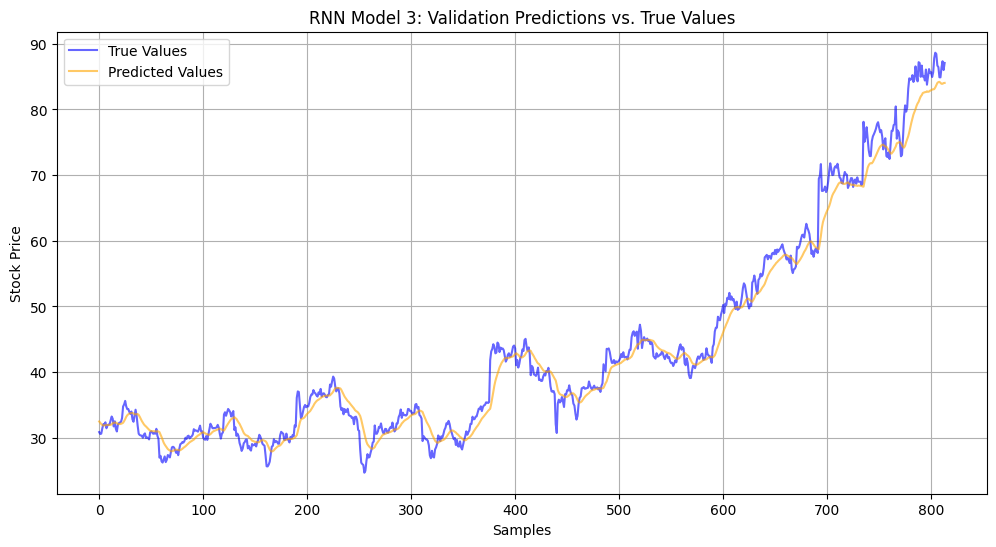

In [81]:
plot_full_validation_predictions(modelRNN3, X_val, y_val, scaler, model_name="RNN Model 3")

### RNN model 4, decreasing learning rate to 0.0001

In [82]:
# Define the RNN model with decreased learning rate
hidden_size = 128  # Keep the hidden size constant
num_layers = 2  # Keep the number of layers constant
learning_rate = 0.0001  # Decrease the learning rate for this experiment

print(f"Experimenting with RNN - Hidden Size: {hidden_size}, Layers: {num_layers}, Learning Rate: {learning_rate}")
# Initialize the RNN model
modelRNN4 = StockPriceRNN(
    input_size=input_size,
    hidden_size=hidden_size,
    num_layers=num_layers,
    output_size=output_size,
    rnn_type="RNN"
).to(device)

# Loss functions and optimizer
criterion_mse = nn.MSELoss()
criterion_mae = nn.L1Loss()
optimizer = optim.Adam(modelRNN4.parameters(), lr=learning_rate)


Experimenting with RNN - Hidden Size: 128, Layers: 2, Learning Rate: 0.0001


In [83]:
# Track training and validation losses
train_mse_vals, train_mae_vals = [], []  # Lists to store training losses
val_mse_vals, val_mae_vals = [], []  # Lists to store validation losses

# Initialize variables for best validation MSE tracking
best_val_mse = float('inf')  # Start with a very high MSE value
best_model_path = "best_modelRNN4.pth"  # Path to save the best model
best_epoch = -1  # Variable to store the epoch of the best model
best_val_mae = None  # Variable to store the corresponding MAE of the best model

# Training loop
for epoch in range(num_epochs):
    # Training phase
    modelRNN4.train()
    optimizer.zero_grad()
    outputs = modelRNN4(X_train)
    train_loss_mse = criterion_mse(outputs, y_train)
    train_loss_mae = criterion_mae(outputs, y_train)
    train_loss_mse.backward()
    optimizer.step()

    # Inverse scaling for training metrics
    outputs_original = scaler.inverse_transform(outputs.detach().cpu().numpy())
    y_train_original = scaler.inverse_transform(y_train.cpu().numpy())

    train_mse_original = ((outputs_original - y_train_original) ** 2).mean()
    train_mae_original = abs(outputs_original - y_train_original).mean()

    # Record training losses
    train_mse_vals.append(train_mse_original)
    train_mae_vals.append(train_mae_original)

    # Validation phase
    modelRNN4.eval()
    with torch.no_grad():
        val_outputs = modelRNN4(X_val)
        val_loss_mse = criterion_mse(val_outputs, y_val)
        val_loss_mae = criterion_mae(val_outputs, y_val)

        # Inverse scaling for validation metrics
        val_outputs_original = scaler.inverse_transform(val_outputs.cpu().numpy())
        y_val_original = scaler.inverse_transform(y_val.cpu().numpy())

        val_mse_original = ((val_outputs_original - y_val_original) ** 2).mean()
        val_mae_original = abs(val_outputs_original - y_val_original).mean()

        # Record validation losses
        val_mse_vals.append(val_mse_original)
        val_mae_vals.append(val_mae_original)

        # Save the model if validation MSE improves
        if val_mse_original < best_val_mse:
            best_val_mse = val_mse_original
            best_epoch = epoch + 1
            best_val_mae = val_mae_original
            torch.save(modelRNN4.state_dict(), best_model_path)


In [84]:
print(f"Best Model Saved at Epoch {best_epoch}, with Validation MSE: {best_val_mse:.6f}, "
      f"and Validation MAE: {best_val_mae:.6f}")

Best Model Saved at Epoch 14, with Validation MSE: 286.442963, and Validation MAE: 11.538760


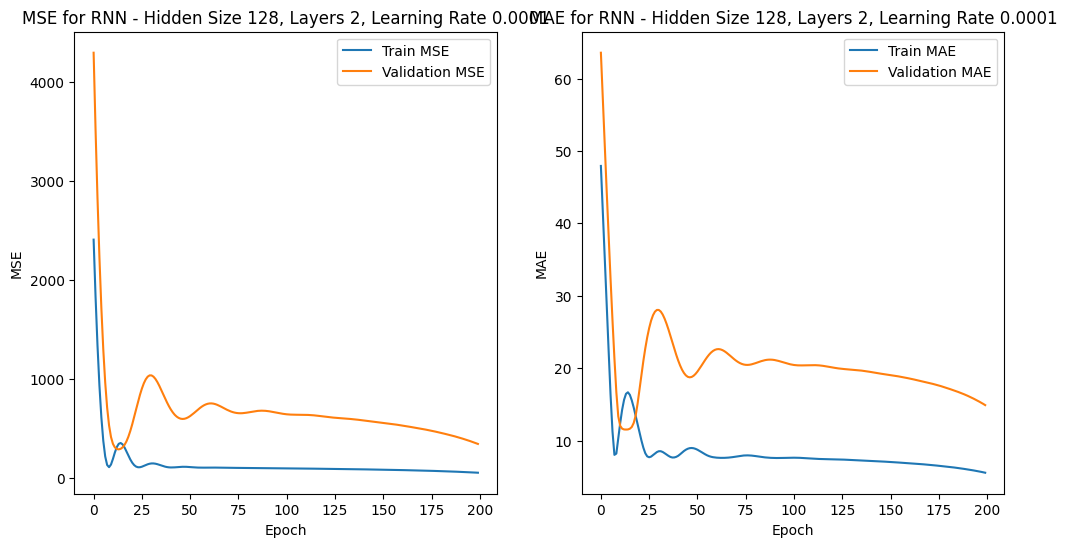

In [85]:
# Plot training and validation losses
plt.figure(figsize=(12, 6))

# Plot MSE
plt.subplot(1, 2, 1)
plt.plot(train_mse_vals, label='Train MSE')
plt.plot(val_mse_vals, label='Validation MSE')
plt.title(f'MSE for RNN - Hidden Size {hidden_size}, Layers {num_layers}, Learning Rate {learning_rate}')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(train_mae_vals, label='Train MAE')
plt.plot(val_mae_vals, label='Validation MAE')
plt.title(f'MAE for RNN - Hidden Size {hidden_size}, Layers {num_layers}, Learning Rate {learning_rate}')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.show()

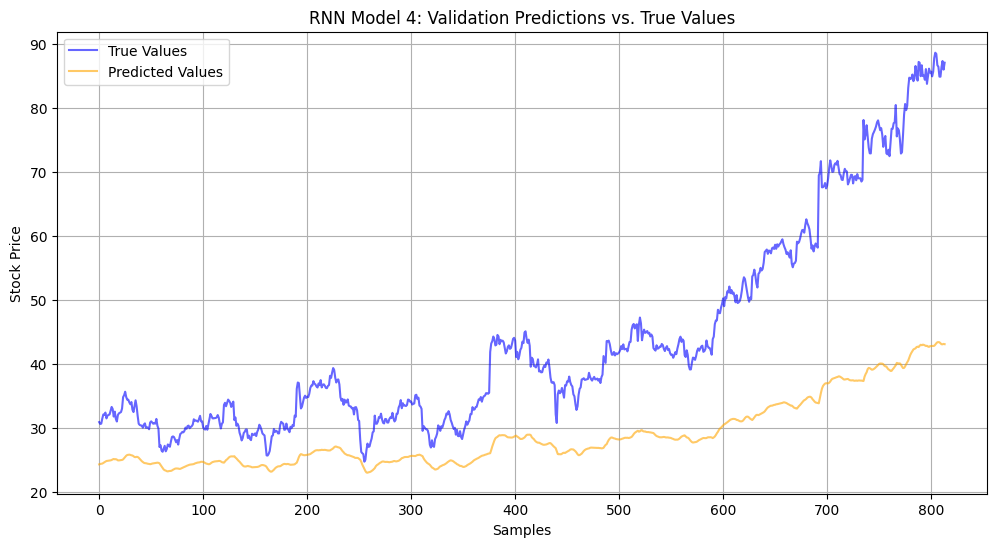

In [86]:
plot_full_validation_predictions(modelRNN4, X_val, y_val, scaler, model_name="RNN Model 4")

### RNN model 5, increase sequence length to 60

In [87]:
# Increase sequence length for this experiment
seq_length = 60  # Increased sequence length
print(f"Experimenting with RNN - Sequence Length: {seq_length}, Hidden Size: 128, Layers: 2, Learning Rate: 0.0001")

# Create new sequences with the increased sequence length
X, y = create_sequences(data_normalized, seq_length=seq_length)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)  
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.3, shuffle=False) 

# Convert data to tensors
X_train, y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32)
X_val, y_val = torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32)
X_train, y_train = X_train.to(device), y_train.to(device)
X_val, y_val = X_val.to(device), y_val.to(device)

# Initialize the RNN model
modelRNN5 = StockPriceRNN(
    input_size=input_size,
    hidden_size=128,  # Hidden size remains the same
    num_layers=2,  # Number of layers remains the same
    output_size=output_size,
    rnn_type="RNN"
).to(device)

# Loss functions and optimizer
criterion_mse = nn.MSELoss()
criterion_mae = nn.L1Loss()
optimizer = optim.Adam(modelRNN5.parameters(), lr=0.0001)  # Keep learning rate from the previous experiment


Experimenting with RNN - Sequence Length: 60, Hidden Size: 128, Layers: 2, Learning Rate: 0.0001


In [88]:
# Track training and validation losses
train_mse_vals, train_mae_vals = [], []  # Lists to store training losses
val_mse_vals, val_mae_vals = [], []  # Lists to store validation losses

# Initialize variables for best validation MSE tracking
best_val_mse = float('inf')  # Start with a very high MSE value
best_model_path = "best_modelRNN5.pth"  # Path to save the best model
best_epoch = -1  # Variable to store the epoch of the best model
best_val_mae = None  # Variable to store the corresponding MAE of the best model

# Training loop
for epoch in range(num_epochs):
    # Training phase
    modelRNN5.train()
    optimizer.zero_grad()
    outputs = modelRNN5(X_train)
    train_loss_mse = criterion_mse(outputs, y_train)
    train_loss_mae = criterion_mae(outputs, y_train)
    train_loss_mse.backward()
    optimizer.step()

    # Inverse scaling for training metrics
    outputs_original = scaler.inverse_transform(outputs.detach().cpu().numpy())
    y_train_original = scaler.inverse_transform(y_train.cpu().numpy())

    train_mse_original = ((outputs_original - y_train_original) ** 2).mean()
    train_mae_original = abs(outputs_original - y_train_original).mean()

    # Record training losses
    train_mse_vals.append(train_mse_original)
    train_mae_vals.append(train_mae_original)

    # Validation phase
    modelRNN5.eval()
    with torch.no_grad():
        val_outputs = modelRNN5(X_val)
        val_loss_mse = criterion_mse(val_outputs, y_val)
        val_loss_mae = criterion_mae(val_outputs, y_val)

        # Inverse scaling for validation metrics
        val_outputs_original = scaler.inverse_transform(val_outputs.cpu().numpy())
        y_val_original = scaler.inverse_transform(y_val.cpu().numpy())

        val_mse_original = ((val_outputs_original - y_val_original) ** 2).mean()
        val_mae_original = abs(val_outputs_original - y_val_original).mean()

        # Record validation losses
        val_mse_vals.append(val_mse_original)
        val_mae_vals.append(val_mae_original)

        # Save the model if validation MSE improves
        if val_mse_original < best_val_mse:
            best_val_mse = val_mse_original
            best_epoch = epoch + 1
            best_val_mae = val_mae_original
            torch.save(modelRNN5.state_dict(), best_model_path)


In [89]:
print(f"Best Model Saved at Epoch {best_epoch}, with Validation MSE: {best_val_mse:.6f}, "
      f"and Validation MAE: {best_val_mae:.6f}")

Best Model Saved at Epoch 101, with Validation MSE: 3.787638, and Validation MAE: 1.437693


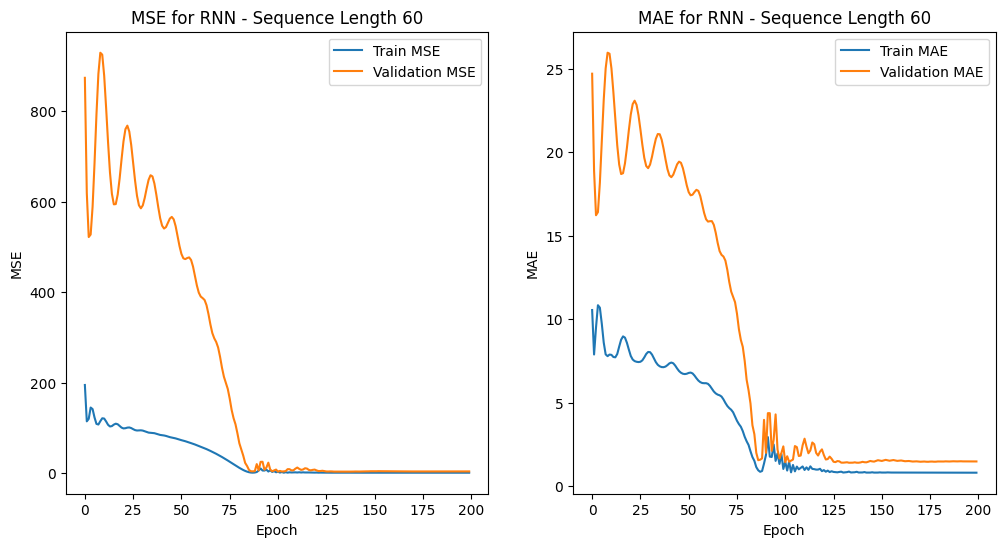

In [90]:
# Plot training and validation losses
plt.figure(figsize=(12, 6))

# Plot MSE
plt.subplot(1, 2, 1)
plt.plot(train_mse_vals, label='Train MSE')
plt.plot(val_mse_vals, label='Validation MSE')
plt.title(f'MSE for RNN - Sequence Length {seq_length}')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(train_mae_vals, label='Train MAE')
plt.plot(val_mae_vals, label='Validation MAE')
plt.title(f'MAE for RNN - Sequence Length {seq_length}')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.show()

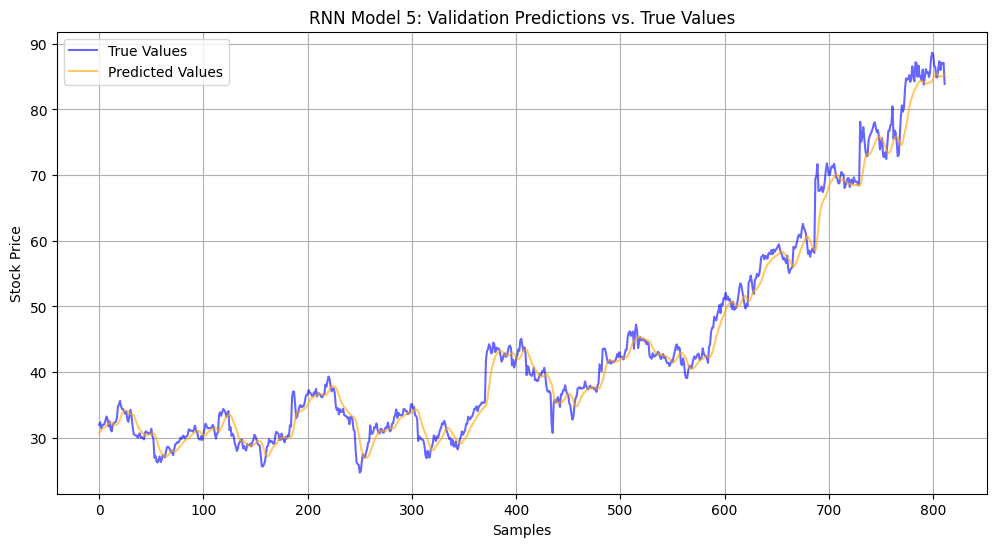

In [91]:
plot_full_validation_predictions(modelRNN5, X_val, y_val, scaler, model_name="RNN Model 5")

### model 6, icreasing batch size and epochs

In [92]:
from torch.utils.data import DataLoader, TensorDataset

# Parameters for this experiment
seq_length = 50  # Keep sequence length from the previous experiment
batch_size = 64  # Increase batch size
num_epochs = 300  # Increase number of epochs
print(f"Experimenting with RNN - Batch Size: {batch_size}, Epochs: {num_epochs}, Sequence Length: {seq_length}")

# Create new sequences with the increased sequence length
X, y = create_sequences(data_normalized, seq_length=seq_length)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)  
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.3, shuffle=False) 

# Convert data to tensors
X_train, y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32)
X_val, y_val = torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32)
X_train, y_train = X_train.to(device), y_train.to(device)
X_val, y_val = X_val.to(device), y_val.to(device)

# Create DataLoader for batching
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Initialize the RNN model
modelRNN6 = StockPriceRNN(
    input_size=input_size,
    hidden_size=128,  # Hidden size remains the same
    num_layers=2,  # Number of layers remains the same
    output_size=output_size,
    rnn_type="RNN"
).to(device)

# Loss functions and optimizer
criterion_mse = nn.MSELoss()
criterion_mae = nn.L1Loss()
optimizer = optim.Adam(modelRNN6.parameters(), lr=0.0001)


Experimenting with RNN - Batch Size: 64, Epochs: 300, Sequence Length: 50


In [93]:
# Track training and validation losses
train_mse_vals, train_mae_vals = [], []  # Lists to store training losses
val_mse_vals, val_mae_vals = [], []  # Lists to store validation losses

# Initialize variables for best validation MSE tracking
best_val_mse = float('inf')  # Start with a very high MSE value
best_model_path = "best_modelRNN6.pth"  # Path to save the best model
best_epoch = -1  # Variable to store the epoch of the best model
best_val_mae = None  # Variable to store the corresponding MAE of the best model

# Training loop
for epoch in range(num_epochs):
    # Training phase
    modelRNN6.train()
    epoch_train_mse, epoch_train_mae = 0.0, 0.0
    epoch_train_original_mse, epoch_train_original_mae = 0.0, 0.0  # For original-scale metrics
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = modelRNN6(X_batch)
        loss_mse = criterion_mse(outputs, y_batch)
        loss_mae = criterion_mae(outputs, y_batch)
        loss_mse.backward()
        optimizer.step()
        epoch_train_mse += loss_mse.item() * len(X_batch)
        epoch_train_mae += loss_mae.item() * len(X_batch)

        # Compute original-scale metrics
        outputs_original = scaler.inverse_transform(outputs.detach().cpu().numpy())
        y_batch_original = scaler.inverse_transform(y_batch.cpu().numpy())
        epoch_train_original_mse += ((outputs_original - y_batch_original) ** 2).sum()
        epoch_train_original_mae += abs(outputs_original - y_batch_original).sum()

    train_mse_vals.append(epoch_train_original_mse / len(train_loader.dataset))
    train_mae_vals.append(epoch_train_original_mae / len(train_loader.dataset))

    # Validation phase
    modelRNN6.eval()
    epoch_val_mse, epoch_val_mae = 0.0, 0.0
    epoch_val_original_mse, epoch_val_original_mae = 0.0, 0.0  # For original-scale metrics
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            val_outputs = modelRNN6(X_batch)
            loss_mse = criterion_mse(val_outputs, y_batch)
            loss_mae = criterion_mae(val_outputs, y_batch)
            epoch_val_mse += loss_mse.item() * len(X_batch)
            epoch_val_mae += loss_mae.item() * len(X_batch)

            # Compute original-scale metrics
            val_outputs_original = scaler.inverse_transform(val_outputs.cpu().numpy())
            y_batch_original = scaler.inverse_transform(y_batch.cpu().numpy())
            epoch_val_original_mse += ((val_outputs_original - y_batch_original) ** 2).sum()
            epoch_val_original_mae += abs(val_outputs_original - y_batch_original).sum()

    val_mse_vals.append(epoch_val_original_mse / len(val_loader.dataset))
    val_mae_vals.append(epoch_val_original_mae / len(val_loader.dataset))

    # Save the model if validation MSE improves
    if val_mse_vals[-1] < best_val_mse:
        best_val_mse = val_mse_vals[-1]
        best_epoch = epoch + 1
        best_val_mae = val_mae_vals[-1]
        torch.save(modelRNN6.state_dict(), best_model_path)

    # Print loss information every 50 epochs or at the first epoch
    if (epoch + 1) % 50 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train MSE : {train_mse_vals[-1]:.4f}, Val MSE : {val_mse_vals[-1]:.4f}, "
              f"Train MAE : {train_mae_vals[-1]:.4f}, Val MAE : {val_mae_vals[-1]:.4f}")


Epoch [1/300], Train MSE : 136.3658, Val MSE : 764.7631, Train MAE : 9.1281, Val MAE : 22.8853
Epoch [50/300], Train MSE : 1.0112, Val MSE : 3.8420, Train MAE : 0.7167, Val MAE : 1.4541
Epoch [100/300], Train MSE : 0.7764, Val MSE : 2.3550, Train MAE : 0.6427, Val MAE : 1.0525
Epoch [150/300], Train MSE : 0.7455, Val MSE : 2.3496, Train MAE : 0.6416, Val MAE : 1.1125
Epoch [200/300], Train MSE : 0.5495, Val MSE : 1.4484, Train MAE : 0.5313, Val MAE : 0.7971
Epoch [250/300], Train MSE : 0.5142, Val MSE : 1.5873, Train MAE : 0.5152, Val MAE : 0.8405
Epoch [300/300], Train MSE : 0.4444, Val MSE : 1.4299, Train MAE : 0.4715, Val MAE : 0.8224


In [94]:
print(f"Best Model Saved at Epoch {best_epoch}, with Validation MSE: {best_val_mse:.6f}, "
      f"and Validation MAE: {best_val_mae:.6f}")

Best Model Saved at Epoch 290, with Validation MSE: 1.276089, and Validation MAE: 0.736351


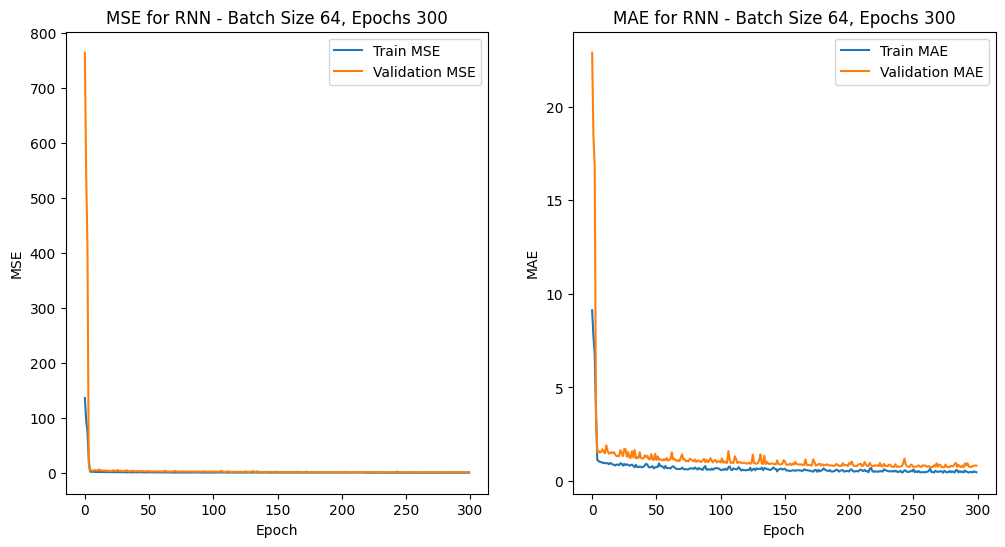

In [95]:
# Plot training and validation losses
plt.figure(figsize=(12, 6))

# Plot MSE
plt.subplot(1, 2, 1)
plt.plot(train_mse_vals, label='Train MSE')
plt.plot(val_mse_vals, label='Validation MSE')
plt.title(f'MSE for RNN - Batch Size {batch_size}, Epochs {num_epochs}')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(train_mae_vals, label='Train MAE')
plt.plot(val_mae_vals, label='Validation MAE')
plt.title(f'MAE for RNN - Batch Size {batch_size}, Epochs {num_epochs}')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.show()

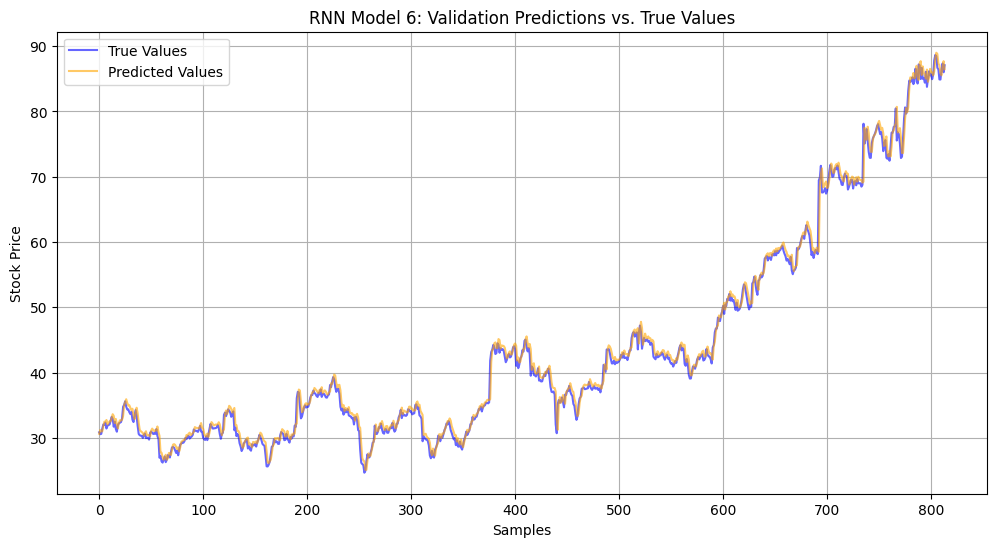

In [96]:
plot_full_validation_predictions(modelRNN6, X_val, y_val, scaler, model_name="RNN Model 6")

In [103]:
# Updated data for all models
data_updated = {
    "Index": range(1, 19),
    "Model": [
        "modelGRU", "modelGRU2", "modelGRU3", "modelGRU4", "modelGRU5", "modelGRU6",
        "modelLSTM", "modelLSTM2", "modelLSTM3", "modelLSTM4", "modelLSTM5", "modelLSTM6",
        "modelRNN", "modelRNN2", "modelRNN3", "modelRNN4", "modelRNN5", "modelRNN6"
    ],
    "Validation MSE": [
        3.500524, 2.974770, 3.174400, 403.437225, 4.079564, 1.416763,
        7.485833, 7.082099, 561.826599, 6.752887, 577.529114, 2.590556,
        4.570542, 3.755842, 4.420590, 286.442963, 3.787638, 1.276089
    ],
    "Validation MAE": [
        1.359184, 1.210085, 1.252866, 13.230080, 1.506956, 0.786120,
        2.131706, 2.090762, 17.414078, 2.034480, 17.879435, 1.103391,
        1.604003, 1.390512, 1.566453, 11.538760, 1.437693, 0.736351
    ]
}

# Create updated DataFrame for all models
df_updated_all = pd.DataFrame(data_updated)

# Filter the top 3 models based on updated Validation MSE
df_updated_top3 = df_updated_all.nsmallest(3, "Validation MSE").reset_index(drop=True)
df_updated_top3["Index"] = range(1, 4)

# Display the updated tables
print("Updated Comparison of All Models")
print(df_updated_all.to_string(index=False))

print("\nUpdated Top 3 Models by Validation MSE")
print(df_updated_top3.to_string(index=False))


Updated Comparison of All Models
 Index      Model  Validation MSE  Validation MAE
     1   modelGRU        3.500524        1.359184
     2  modelGRU2        2.974770        1.210085
     3  modelGRU3        3.174400        1.252866
     4  modelGRU4      403.437225       13.230080
     5  modelGRU5        4.079564        1.506956
     6  modelGRU6        1.416763        0.786120
     7  modelLSTM        7.485833        2.131706
     8 modelLSTM2        7.082099        2.090762
     9 modelLSTM3      561.826599       17.414078
    10 modelLSTM4        6.752887        2.034480
    11 modelLSTM5      577.529114       17.879435
    12 modelLSTM6        2.590556        1.103391
    13   modelRNN        4.570542        1.604003
    14  modelRNN2        3.755842        1.390512
    15  modelRNN3        4.420590        1.566453
    16  modelRNN4      286.442963       11.538760
    17  modelRNN5        3.787638        1.437693
    18  modelRNN6        1.276089        0.736351

Updated Top 3 Mo

# Best model was RNN model 6

#### Both GRU model 6 and RNN model 6 achieved a very desirable MSE values, but since both the MSE and MAE was lower for the RNN model 6 we will use that for our evaluation.

### Model Performance Comparison

| Model          | MSE       | MAE        |
|----------------|-----------|------------|
| RNN Model 6    | 1.276089  | 0.736351   |
| GRU Model 6    | 1.416763  | 0.786120   |
| LSTM Basemodel | 2.590556  | 1.103391   |


### Evaluting our best model on testing set

In [99]:
from sklearn.metrics import  mean_squared_error, mean_absolute_error
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [105]:
# Load the best saved model for evaluation
modelRNN6.load_state_dict(torch.load("best_modelRNN6.pth"))  # Load the best model
modelRNN6.eval()  # Set the model to evaluation mode


C:\Users\Abdul\AppData\Local\Temp\ipykernel_7124\4119086978.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  modelRNN6.load_state_dict(torch.load("best_modelRNN6.pth"))  

StockPriceRNN(
  (rnn): RNN(1, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

In [106]:
# Prepare the test data
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

# Evaluate the model on the test set
with torch.no_grad():  # Disable gradient computation
    test_outputs = modelRNN6(X_test_tensor)  # Make predictions on the test set

# Denormalize predictions and ground truth (if scaled)
y_test_pred = test_outputs.cpu().numpy()
y_test_true = y_test_tensor.cpu().numpy()

# Assuming a scaler object was used for preprocessing
y_test_pred_original = scaler.inverse_transform(y_test_pred)
y_test_true_original = scaler.inverse_transform(y_test_true)

# Calculate original-scale MSE and MAE
test_mse_original = ((y_test_pred_original - y_test_true_original) ** 2).mean()
test_mae_original = abs(y_test_pred_original - y_test_true_original).mean()

# Print evaluation results
print(f"Test MSE for modelRNN6 : {test_mse_original:.4f}")
print(f"Test MAE for modelRNN6 : {test_mae_original:.4f}")

Test MSE for modelRNN6 : 59.2447
Test MAE for modelRNN6 : 5.4896


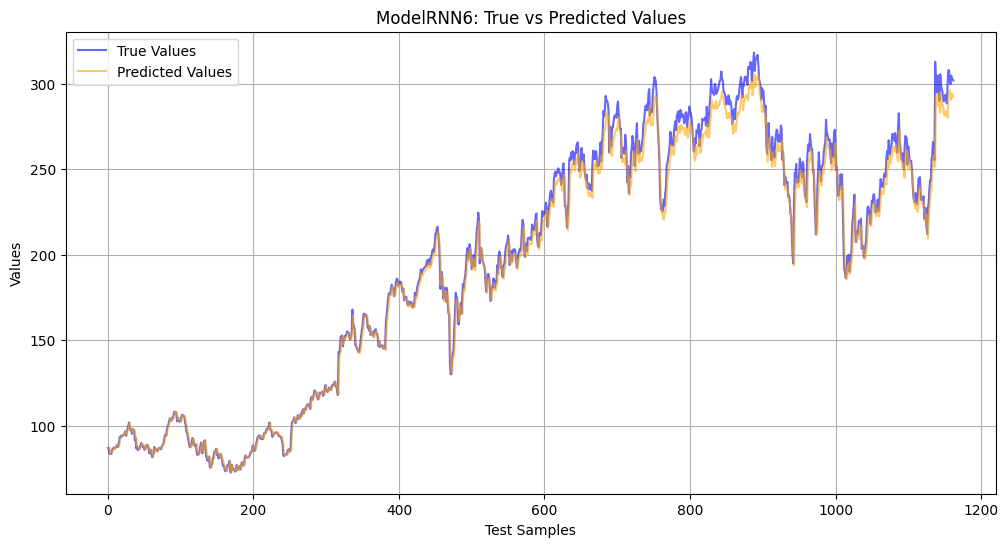

: 

In [ ]:
# Visualization for the entire dataset
plt.figure(figsize=(12, 6))
plt.plot(y_test_true_original, label="True Values", alpha=0.6, color='blue')
plt.plot(y_test_pred_original, label="Predicted Values", alpha=0.6, color='orange')
plt.title("ModelRNN6: True vs Predicted Values")
plt.xlabel("Test Samples")
plt.ylabel("Values")
plt.legend()
plt.grid(True)
plt.show()